In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return torch.cos(t) - torch.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return torch.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (torch.pi/2*torch.cos(x) + (x - torch.pi/2)) * torch.cos(t)

In [3]:
def gen_data(L, t_end, n_t, n_x=5):
    "generates data in a way that mimics sensors. n_x is number of sensors, n_t is number of time points per sensor"
    x_coords = torch.linspace(0, L, n_x)
    t_times = torch.linspace(0, t_end, n_t)

    x_vals = x_coords.repeat_interleave(n_t)
    t_vals = t_times.repeat(n_x)
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals), theta_exact(x_vals, t_vals))

In [4]:
def split_train_val(val_frac, *tensors):
    N = tensors[0].shape[0]
    perm = torch.randperm(N)
    n_val = int(N * val_frac)
    val_idx, train_idx = perm[:n_val], perm[n_val:]
    return (tuple(t[train_idx] for t in tensors),
            tuple(t[val_idx]   for t in tensors))

In [5]:
# training data generation
t_end = 2*torch.pi
t_interval = 0.1
num_sensors = 5

generated_data = gen_data(torch.pi, t_end, int(t_end/t_interval), num_sensors)
(x_gen, t_gen, f_gen, u_gen, theta_gen), (x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val) = split_train_val(0.1, *generated_data)

In [6]:
print(int(t_end/t_interval)*num_sensors)  # number of training points

310


In [7]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [9]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300

validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [30]:
# save the normalizers to use in result file
torch.save({
    "x_mean": x_normalizer.normmean,
    "x_std": x_normalizer.normstd,
    "t_mean": t_normalizer.normmean,
    "t_std": t_normalizer.normstd,
    "u_mean": u_normalizer.normmean,
    "u_std": u_normalizer.normstd,
    "theta_mean": theta_normalizer.normmean,
    "theta_std": theta_normalizer.normstd,
}, "normalizers_L2.pt")

In [10]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [11]:
# Define parameters
L = torch.pi
T_end = t_end

# Set sample sizes
N_f = 10000 #2000   # collocation points in interior
N_ic = 2000 #256   # initial condition samples at t=0
N_bc = 2000 #256   # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 250

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.7324634191189479
lambda_ic = 0.33169472587793747
lambda_bc = 0.14122575733247608
lambda_physics = 0.1361579824702817

lambdas = (lambda_data, lambda_ic, lambda_bc, lambda_physics)
# echo on screen
echo_every = 75


In [12]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            # ---------------------- student exercise --------------------------------- #
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())
            # ---------------------- student exercise --------------------------------- #

    return np.array(losses).mean()

In [13]:
def training_loop(pinn, optimiser, trial, lambdas):    
    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()

    lambda_data, lambda_ic, lambda_bc, lambda_physics = lambdas

    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        full_pred_data_norm = pinn(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
        loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
        loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

        # compute boundary loss
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = ((dudt - 0)**2).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = ((dthetadt - 0)**2).mean()

        loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = ((u - 0)**2).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = ((theta - 0)**2).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = ((u - 0)**2).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = ((theta - 0)**2).mean()

        loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

        #compute physics loss
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm
        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm
        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(physics_residual_1**2)
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
        loss_physics_2 = torch.mean(physics_residual_2**2)

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())
        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            #print(f"Epoch {i}: total loss = {loss}, loss1 = {loss1}, loss2 = {loss2}, loss3 = {loss3}, loss4 = {loss4}, loss5 = {loss5}, loss6 = {loss6}, loss7 = {loss7}, loss_data_u = {loss_data_u}, loss_data_theta = {loss_data_theta}")
            print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")
        
            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()
        # Check if the trial has exceeded the maximum allowed time
        
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()

    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

The objective function ```objective_architecture``` optimises the architecture of the model. It is used by optuna to optimise the ```hidden_size```, ```num_layers``` and the ```learning_rate``` hyperparameters. The optimiser was also included in this optimisation, but after consistently showing Adam to be the best optimiser for this problem. These lines were then deactivated to reduce the solution space explored by optuna.

In [14]:
def objective_architecture(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    pinn = MLP(2,hidden_size,2, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.Adam(pinn.parameters(),lr=learning_rate)
    validation_loss = training_loop(pinn, optimiser, trial, lambdas=lambdas)

    return validation_loss

The objective function ```objective_lamdas``` uses a model with the hyperparameters found by the architecture study, then trains a model to optimise the weights of the data, initial conditions, boundary conditions and physics losses. This is an important step to get stable, regularised training, as these losses dont all share the same units, and therefore dont have the same orders of magnitude.

In [15]:
def objective_lambdas(trial_w):
    lambda_data = trial_w.suggest_float('lambda_data', 0.1, 1, log=True)
    lambda_ic = trial_w.suggest_float('lambda_ic', 0.1, 1)
    lambda_bc = trial_w.suggest_float('lambda_bc', 0.1, 1, log=True)
    lambda_physics = trial_w.suggest_float('lambda_physics', 0.1, 1)

    lambdas_suggested = (lambda_data, lambda_ic, lambda_bc, lambda_physics)

    # setup the PINN with the best architecture found
    # using global variable defined after the cell is not great practice, but cannot easily be avoided due to Optuna structure

    pinn = MLP(2,trial_archi.params['hidden_size'],2, num_hid_layers=trial_archi.params['num_layers']).to(device)   
    optimiser = torch.optim.Adam(pinn.parameters(),lr=trial_archi.params['learning_rate'])

    validation_loss = training_loop(pinn, optimiser, trial_w, lambdas=lambdas_suggested)
    
    return validation_loss

The optuna studies below first optimise the architecture, and then optimise the lambdas using those results.  

In [16]:
# This cell will first optimize the architecture, then optimize the lambdas using the best architecture found.
# Note that this will take a while (~30 minutes with reduced data) to run!
# If you have a model file, you might want to skip this and following cells and continue at the marked cell.

study_architecture = optuna.create_study(direction='minimize')
study_architecture.optimize(objective_architecture, n_trials=50)

pruned_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

trial_archi = study_architecture.best_trial

n_epochs = 250

study_lambdas = optuna.create_study(direction='minimize')
study_lambdas.optimize(objective_lambdas, n_trials=50)
pruned_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# summaries of both studies
print("Study architecture statistics: ")
print("  Number of finished trials: ", len(study_architecture.trials))
print("  Number of pruned trials: ", len(pruned_trials_archi))
print("  Number of complete trials: ", len(complete_trials_archi))

print("Best trial architecture:")


print("  Value: ", trial_archi.value)

print("  Params: ")
for key, value in trial_archi.params.items():
    print("    {}: {}".format(key, value))


print("Study lambdas statistics: ")
print("  Number of finished trials: ", len(study_lambdas.trials))
print("  Number of pruned trials: ", len(pruned_trials_lambdas))
print("  Number of complete trials: ", len(complete_trials_lambdas))
print("Best trial lambdas:")

trial_lambdas = study_lambdas.best_trial
print("  Value: ", trial_lambdas.value)

print("  Params: ")
for key, value in trial_lambdas.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-28 14:50:15,612] A new study created in memory with name: no-name-a7190f35-27e5-42d9-ab44-ad9171601a10


Epoch 0: total loss = 1.811616, Initial_u = 0.922022, Initial_u_t = 0.000798, Initial_theta = 0.053755, Initial_theta_t = 0.000004, BC_left_u = 0.021027, BC_left_theta = 0.000029, BC_right_u = 0.009548, BC_right_theta = 0.000032, Physics_1 = 0.004549, Physics_2 = 0.112789
Validation loss at epoch 0: 0.797027
Epoch 75: total loss = 0.413812, Initial_u = 0.037427, Initial_u_t = 0.042860, Initial_theta = 0.006758, Initial_theta_t = 0.014307, BC_left_u = 0.050872, BC_left_theta = 0.006998, BC_right_u = 0.042119, BC_right_theta = 0.007696, Physics_1 = 0.097436, Physics_2 = 0.309289
Validation loss at epoch 75: 0.195504
Epoch 150: total loss = 0.116690, Initial_u = 0.006101, Initial_u_t = 0.010737, Initial_theta = 0.001004, Initial_theta_t = 0.010147, BC_left_u = 0.015490, BC_left_theta = 0.001053, BC_right_u = 0.012910, BC_right_theta = 0.001101, Physics_1 = 0.274943, Physics_2 = 0.176308
Validation loss at epoch 150: 0.018513
Epoch 225: total loss = 0.063189, Initial_u = 0.001460, Initial_

[I 2026-01-28 14:50:48,141] Trial 0 finished with value: 0.007411819417029619 and parameters: {'hidden_size': 450, 'learning_rate': 0.00016366740639471916, 'num_layers': 2}. Best is trial 0 with value: 0.007411819417029619.


  Params: 
    hidden_size: 450
    learning_rate: 0.00016366740639471916
    num_layers: 2
Epoch 0: total loss = 2.058907, Initial_u = 1.436021, Initial_u_t = 0.000963, Initial_theta = 0.058127, Initial_theta_t = 0.000015, BC_left_u = 0.049867, BC_left_theta = 0.000071, BC_right_u = 0.079748, BC_right_theta = 0.000052, Physics_1 = 0.026496, Physics_2 = 0.119583
Validation loss at epoch 0: 6.084035
Epoch 75: total loss = 0.108614, Initial_u = 0.018718, Initial_u_t = 0.016617, Initial_theta = 0.000722, Initial_theta_t = 0.013416, BC_left_u = 0.016371, BC_left_theta = 0.000733, BC_right_u = 0.015897, BC_right_theta = 0.000631, Physics_1 = 0.202638, Physics_2 = 0.151868
Validation loss at epoch 75: 0.019231
Epoch 150: total loss = 0.031483, Initial_u = 0.000674, Initial_u_t = 0.000666, Initial_theta = 0.000269, Initial_theta_t = 0.001560, BC_left_u = 0.007037, BC_left_theta = 0.000154, BC_right_u = 0.006198, BC_right_theta = 0.000180, Physics_1 = 0.073400, Physics_2 = 0.050025
Validation 

[I 2026-01-28 14:51:02,678] Trial 1 finished with value: 0.0019829010125249624 and parameters: {'hidden_size': 350, 'learning_rate': 0.00399112000298784, 'num_layers': 1}. Best is trial 1 with value: 0.0019829010125249624.


  Params: 
    hidden_size: 350
    learning_rate: 0.00399112000298784
    num_layers: 1
Epoch 0: total loss = 1.852403, Initial_u = 1.035171, Initial_u_t = 0.000810, Initial_theta = 0.057961, Initial_theta_t = 0.000005, BC_left_u = 0.022108, BC_left_theta = 0.000192, BC_right_u = 0.017191, BC_right_theta = 0.000203, Physics_1 = 0.008185, Physics_2 = 0.116475
Validation loss at epoch 0: 55.501923
Epoch 75: total loss = 0.384456, Initial_u = 0.050675, Initial_u_t = 0.055086, Initial_theta = 0.007097, Initial_theta_t = 0.018222, BC_left_u = 0.023821, BC_left_theta = 0.001364, BC_right_u = 0.037640, BC_right_theta = 0.002238, Physics_1 = 0.296279, Physics_2 = 0.285375
Validation loss at epoch 75: 0.154588
Epoch 150: total loss = 0.208517, Initial_u = 0.030195, Initial_u_t = 0.026449, Initial_theta = 0.004289, Initial_theta_t = 0.013354, BC_left_u = 0.013074, BC_left_theta = 0.002425, BC_right_u = 0.011113, BC_right_theta = 0.002702, Physics_1 = 0.274579, Physics_2 = 0.126207
Validation lo

[I 2026-01-28 14:51:21,376] Trial 2 finished with value: 0.02775229513645172 and parameters: {'hidden_size': 450, 'learning_rate': 0.029474093999474642, 'num_layers': 1}. Best is trial 1 with value: 0.0019829010125249624.


  Params: 
    hidden_size: 450
    learning_rate: 0.029474093999474642
    num_layers: 1
Epoch 0: total loss = 1.914716, Initial_u = 1.170559, Initial_u_t = 0.000238, Initial_theta = 0.058919, Initial_theta_t = 0.000012, BC_left_u = 0.012641, BC_left_theta = 0.000088, BC_right_u = 0.001012, BC_right_theta = 0.000180, Physics_1 = 0.000518, Physics_2 = 0.116662
Validation loss at epoch 0: 23.312645
Epoch 75: total loss = 0.963234, Initial_u = 0.085035, Initial_u_t = 0.014898, Initial_theta = 0.022198, Initial_theta_t = 0.002116, BC_left_u = 0.007519, BC_left_theta = 0.001386, BC_right_u = 0.036652, BC_right_theta = 0.002644, Physics_1 = 0.434567, Physics_2 = 0.425631
Validation loss at epoch 75: 0.489722
Epoch 150: total loss = 0.715675, Initial_u = 0.015649, Initial_u_t = 0.007171, Initial_theta = 0.009545, Initial_theta_t = 0.005661, BC_left_u = 0.006878, BC_left_theta = 0.005349, BC_right_u = 0.008197, BC_right_theta = 0.007011, Physics_1 = 0.469486, Physics_2 = 0.927705
Validation l

[I 2026-01-28 14:51:51,577] Trial 3 finished with value: 0.09781485050916672 and parameters: {'hidden_size': 450, 'learning_rate': 0.028207318362748302, 'num_layers': 2}. Best is trial 1 with value: 0.0019829010125249624.


  Params: 
    hidden_size: 450
    learning_rate: 0.028207318362748302
    num_layers: 2
Epoch 0: total loss = 1.951636, Initial_u = 1.376182, Initial_u_t = 0.000038, Initial_theta = 0.052771, Initial_theta_t = 0.000000, BC_left_u = 0.000139, BC_left_theta = 0.000058, BC_right_u = 0.004934, BC_right_theta = 0.000010, Physics_1 = 0.000688, Physics_2 = 0.119656
Validation loss at epoch 0: 1.827986
Epoch 75: total loss = 0.526784, Initial_u = 0.086558, Initial_u_t = 0.014663, Initial_theta = 0.004842, Initial_theta_t = 0.012173, BC_left_u = 0.205237, BC_left_theta = 0.017022, BC_right_u = 0.105880, BC_right_theta = 0.005915, Physics_1 = 0.361246, Physics_2 = 0.193023
Validation loss at epoch 75: 0.257199
Epoch 150: total loss = 0.057630, Initial_u = 0.002349, Initial_u_t = 0.001431, Initial_theta = 0.000634, Initial_theta_t = 0.004914, BC_left_u = 0.007427, BC_left_theta = 0.000570, BC_right_u = 0.005823, BC_right_theta = 0.000345, Physics_1 = 0.177985, Physics_2 = 0.075132
Validation lo

[I 2026-01-28 14:53:36,136] Trial 4 finished with value: 0.0037441386375576258 and parameters: {'hidden_size': 500, 'learning_rate': 0.001273859290990301, 'num_layers': 3}. Best is trial 1 with value: 0.0019829010125249624.


  Params: 
    hidden_size: 500
    learning_rate: 0.001273859290990301
    num_layers: 3
Epoch 0: total loss = 1.889888, Initial_u = 1.134636, Initial_u_t = 0.000052, Initial_theta = 0.055380, Initial_theta_t = 0.000002, BC_left_u = 0.000033, BC_left_theta = 0.000056, BC_right_u = 0.000074, BC_right_theta = 0.001340, Physics_1 = 0.000622, Physics_2 = 0.113822
Validation loss at epoch 0: 3.373625
Epoch 75: total loss = 0.067374, Initial_u = 0.001695, Initial_u_t = 0.000840, Initial_theta = 0.000337, Initial_theta_t = 0.003488, BC_left_u = 0.006801, BC_left_theta = 0.000866, BC_right_u = 0.009143, BC_right_theta = 0.000846, Physics_1 = 0.159978, Physics_2 = 0.074880
Validation loss at epoch 75: 0.009958
Epoch 150: total loss = 0.024538, Initial_u = 0.000302, Initial_u_t = 0.000116, Initial_theta = 0.000036, Initial_theta_t = 0.000265, BC_left_u = 0.004648, BC_left_theta = 0.000433, BC_right_u = 0.003140, BC_right_theta = 0.000233, Physics_1 = 0.054417, Physics_2 = 0.032683
Validation lo

[I 2026-01-28 14:53:47,020] Trial 5 finished with value: 0.0014765100786462426 and parameters: {'hidden_size': 100, 'learning_rate': 0.013415637091738845, 'num_layers': 2}. Best is trial 5 with value: 0.0014765100786462426.


  Params: 
    hidden_size: 100
    learning_rate: 0.013415637091738845
    num_layers: 2
Epoch 0: total loss = 1.915047, Initial_u = 1.254917, Initial_u_t = 0.000012, Initial_theta = 0.055338, Initial_theta_t = 0.000002, BC_left_u = 0.000797, BC_left_theta = 0.000007, BC_right_u = 0.000061, BC_right_theta = 0.000312, Physics_1 = 0.000181, Physics_2 = 0.116281
Validation loss at epoch 0: 0.826099
Epoch 75: total loss = 0.184514, Initial_u = 0.016869, Initial_u_t = 0.024187, Initial_theta = 0.002195, Initial_theta_t = 0.010243, BC_left_u = 0.031484, BC_left_theta = 0.002088, BC_right_u = 0.017754, BC_right_theta = 0.002064, Physics_1 = 0.313494, Physics_2 = 0.248042
Validation loss at epoch 75: 0.043096


[I 2026-01-28 14:53:55,844] Trial 6 pruned. 


Epoch 150: total loss = 0.069401, Initial_u = 0.002724, Initial_u_t = 0.003373, Initial_theta = 0.000588, Initial_theta_t = 0.005469, BC_left_u = 0.010822, BC_left_theta = 0.000739, BC_right_u = 0.008175, BC_right_theta = 0.000441, Physics_1 = 0.175870, Physics_2 = 0.101774
Validation loss at epoch 150: 0.018171
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.001800539275468192
    num_layers: 3
Epoch 0: total loss = 1.825382, Initial_u = 0.966042, Initial_u_t = 0.000473, Initial_theta = 0.060837, Initial_theta_t = 0.000003, BC_left_u = 0.009143, BC_left_theta = 0.000281, BC_right_u = 0.001408, BC_right_theta = 0.000113, Physics_1 = 0.001348, Physics_2 = 0.119184
Validation loss at epoch 0: 2.074392
Epoch 75: total loss = 0.135314, Initial_u = 0.010862, Initial_u_t = 0.010613, Initial_theta = 0.001083, Initial_theta_t = 0.009442, BC_left_u = 0.018938, BC_left_theta = 0.001864, BC_right_u = 0.015704, BC_right_theta = 0.001544, Physics_1 = 0.279750, Physics_2 = 0.212525
Vali

[I 2026-01-28 14:54:18,181] Trial 7 finished with value: 0.0017487858422100544 and parameters: {'hidden_size': 350, 'learning_rate': 0.0015719784308948573, 'num_layers': 2}. Best is trial 5 with value: 0.0014765100786462426.


  Params: 
    hidden_size: 350
    learning_rate: 0.0015719784308948573
    num_layers: 2
Epoch 0: total loss = 1.882847, Initial_u = 1.141198, Initial_u_t = 0.000092, Initial_theta = 0.055624, Initial_theta_t = 0.000001, BC_left_u = 0.020365, BC_left_theta = 0.000036, BC_right_u = 0.007417, BC_right_theta = 0.000032, Physics_1 = 0.005548, Physics_2 = 0.119039
Validation loss at epoch 0: 0.727063


[I 2026-01-28 14:54:22,241] Trial 8 pruned. 


Epoch 75: total loss = 0.744300, Initial_u = 0.094452, Initial_u_t = 0.132033, Initial_theta = 0.016773, Initial_theta_t = 0.004184, BC_left_u = 0.082178, BC_left_theta = 0.007242, BC_right_u = 0.091729, BC_right_theta = 0.007669, Physics_1 = 0.029726, Physics_2 = 0.212942
Validation loss at epoch 75: 0.366320
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0002306568430889119
    num_layers: 2
Epoch 0: total loss = 1.830757, Initial_u = 0.950670, Initial_u_t = 0.000247, Initial_theta = 0.054791, Initial_theta_t = 0.000012, BC_left_u = 0.003805, BC_left_theta = 0.000117, BC_right_u = 0.016532, BC_right_theta = 0.000005, Physics_1 = 0.000981, Physics_2 = 0.116059
Validation loss at epoch 0: 5.044768
Epoch 75: total loss = 0.064742, Initial_u = 0.001941, Initial_u_t = 0.001369, Initial_theta = 0.000460, Initial_theta_t = 0.007052, BC_left_u = 0.005853, BC_left_theta = 0.000726, BC_right_u = 0.004421, BC_right_theta = 0.000575, Physics_1 = 0.204631, Physics_2 = 0.071512
Valid

[I 2026-01-28 14:54:36,381] Trial 9 finished with value: 0.0035607879981398582 and parameters: {'hidden_size': 200, 'learning_rate': 0.00873321731993764, 'num_layers': 2}. Best is trial 5 with value: 0.0014765100786462426.


  Params: 
    hidden_size: 200
    learning_rate: 0.00873321731993764
    num_layers: 2
Epoch 0: total loss = 1.901832, Initial_u = 1.030180, Initial_u_t = 0.000026, Initial_theta = 0.063238, Initial_theta_t = 0.000013, BC_left_u = 0.025327, BC_left_theta = 0.001433, BC_right_u = 0.007994, BC_right_theta = 0.002339, Physics_1 = 0.001785, Physics_2 = 0.114885
Validation loss at epoch 0: 0.960985
Epoch 75: total loss = 0.129644, Initial_u = 0.007020, Initial_u_t = 0.015201, Initial_theta = 0.000950, Initial_theta_t = 0.013267, BC_left_u = 0.018533, BC_left_theta = 0.001536, BC_right_u = 0.020034, BC_right_theta = 0.001107, Physics_1 = 0.305867, Physics_2 = 0.164905
Validation loss at epoch 75: 0.025600
Epoch 150: total loss = 0.040772, Initial_u = 0.001281, Initial_u_t = 0.001279, Initial_theta = 0.000387, Initial_theta_t = 0.002904, BC_left_u = 0.006327, BC_left_theta = 0.000298, BC_right_u = 0.005025, BC_right_theta = 0.000221, Physics_1 = 0.120937, Physics_2 = 0.059091
Validation los

[I 2026-01-28 14:54:45,038] Trial 10 finished with value: 0.0014209881192073226 and parameters: {'hidden_size': 50, 'learning_rate': 0.0122515139298286, 'num_layers': 1}. Best is trial 10 with value: 0.0014209881192073226.


  Params: 
    hidden_size: 50
    learning_rate: 0.0122515139298286
    num_layers: 1
Epoch 0: total loss = 2.097316, Initial_u = 1.583774, Initial_u_t = 0.000930, Initial_theta = 0.051378, Initial_theta_t = 0.000003, BC_left_u = 0.047845, BC_left_theta = 0.000517, BC_right_u = 0.061301, BC_right_theta = 0.000550, Physics_1 = 0.020363, Physics_2 = 0.118657
Validation loss at epoch 0: 0.874445
Epoch 75: total loss = 0.112855, Initial_u = 0.006629, Initial_u_t = 0.012028, Initial_theta = 0.001199, Initial_theta_t = 0.011928, BC_left_u = 0.020885, BC_left_theta = 0.001165, BC_right_u = 0.009556, BC_right_theta = 0.000702, Physics_1 = 0.262953, Physics_2 = 0.156929
Validation loss at epoch 75: 0.017548
Epoch 150: total loss = 0.038448, Initial_u = 0.000311, Initial_u_t = 0.000486, Initial_theta = 0.000529, Initial_theta_t = 0.002947, BC_left_u = 0.005482, BC_left_theta = 0.000358, BC_right_u = 0.003887, BC_right_theta = 0.000198, Physics_1 = 0.120511, Physics_2 = 0.052779
Validation loss 

[I 2026-01-28 14:54:53,540] Trial 11 finished with value: 0.0021354525815695524 and parameters: {'hidden_size': 50, 'learning_rate': 0.009713443026866529, 'num_layers': 1}. Best is trial 10 with value: 0.0014209881192073226.


  Params: 
    hidden_size: 50
    learning_rate: 0.009713443026866529
    num_layers: 1
Epoch 0: total loss = 1.950186, Initial_u = 1.346518, Initial_u_t = 0.000095, Initial_theta = 0.056625, Initial_theta_t = 0.000005, BC_left_u = 0.018056, BC_left_theta = 0.000033, BC_right_u = 0.001608, BC_right_theta = 0.000032, Physics_1 = 0.004290, Physics_2 = 0.122943
Validation loss at epoch 0: 0.984074
Epoch 75: total loss = 0.115556, Initial_u = 0.008370, Initial_u_t = 0.015985, Initial_theta = 0.000673, Initial_theta_t = 0.010549, BC_left_u = 0.011540, BC_left_theta = 0.000719, BC_right_u = 0.016718, BC_right_theta = 0.000916, Physics_1 = 0.259249, Physics_2 = 0.211325
Validation loss at epoch 75: 0.018870
Epoch 150: total loss = 0.041271, Initial_u = 0.001823, Initial_u_t = 0.001300, Initial_theta = 0.000391, Initial_theta_t = 0.001548, BC_left_u = 0.006186, BC_left_theta = 0.000224, BC_right_u = 0.009456, BC_right_theta = 0.000328, Physics_1 = 0.105826, Physics_2 = 0.068179
Validation los

[I 2026-01-28 14:55:02,555] Trial 12 finished with value: 0.0011327952379360795 and parameters: {'hidden_size': 50, 'learning_rate': 0.010534340207651987, 'num_layers': 1}. Best is trial 12 with value: 0.0011327952379360795.


  Params: 
    hidden_size: 50
    learning_rate: 0.010534340207651987
    num_layers: 1
Epoch 0: total loss = 1.850439, Initial_u = 0.991954, Initial_u_t = 0.000017, Initial_theta = 0.058923, Initial_theta_t = 0.000009, BC_left_u = 0.034624, BC_left_theta = 0.000749, BC_right_u = 0.000153, BC_right_theta = 0.000056, Physics_1 = 0.002285, Physics_2 = 0.117160
Validation loss at epoch 0: 0.790708


[I 2026-01-28 14:55:05,174] Trial 13 pruned. 


Epoch 75: total loss = 0.206131, Initial_u = 0.019521, Initial_u_t = 0.038078, Initial_theta = 0.003010, Initial_theta_t = 0.016794, BC_left_u = 0.025309, BC_left_theta = 0.002220, BC_right_u = 0.018114, BC_right_theta = 0.003424, Physics_1 = 0.378028, Physics_2 = 0.265522
Validation loss at epoch 75: 0.056246
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.004672211101822658
    num_layers: 1
Epoch 0: total loss = 1.938468, Initial_u = 1.173784, Initial_u_t = 0.000028, Initial_theta = 0.047515, Initial_theta_t = 0.000155, BC_left_u = 0.000597, BC_left_theta = 0.002615, BC_right_u = 0.004138, BC_right_theta = 0.000701, Physics_1 = 0.002938, Physics_2 = 0.117995
Validation loss at epoch 0: 18.993124
Epoch 75: total loss = 0.062175, Initial_u = 0.001843, Initial_u_t = 0.002059, Initial_theta = 0.000608, Initial_theta_t = 0.004438, BC_left_u = 0.005013, BC_left_theta = 0.000392, BC_right_u = 0.008092, BC_right_theta = 0.000369, Physics_1 = 0.184849, Physics_2 = 0.088683
Valida

[I 2026-01-28 14:55:13,945] Trial 14 finished with value: 0.007930619642138481 and parameters: {'hidden_size': 150, 'learning_rate': 0.04904418778416312, 'num_layers': 1}. Best is trial 12 with value: 0.0011327952379360795.


  Params: 
    hidden_size: 150
    learning_rate: 0.04904418778416312
    num_layers: 1
Epoch 0: total loss = 1.973197, Initial_u = 1.357780, Initial_u_t = 0.000296, Initial_theta = 0.058635, Initial_theta_t = 0.000004, BC_left_u = 0.027266, BC_left_theta = 0.000967, BC_right_u = 0.026174, BC_right_theta = 0.000089, Physics_1 = 0.015470, Physics_2 = 0.119007
Validation loss at epoch 0: 0.788574


[I 2026-01-28 14:55:17,056] Trial 15 pruned. 


Epoch 75: total loss = 0.528534, Initial_u = 0.074423, Initial_u_t = 0.098589, Initial_theta = 0.008731, Initial_theta_t = 0.010414, BC_left_u = 0.068318, BC_left_theta = 0.006809, BC_right_u = 0.065274, BC_right_theta = 0.007064, Physics_1 = 0.056212, Physics_2 = 0.221086
Validation loss at epoch 75: 0.251601
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0006061957844431614
    num_layers: 1
Epoch 0: total loss = 1.895509, Initial_u = 1.021034, Initial_u_t = 0.000262, Initial_theta = 0.051794, Initial_theta_t = 0.000020, BC_left_u = 0.007073, BC_left_theta = 0.000132, BC_right_u = 0.023388, BC_right_theta = 0.001889, Physics_1 = 0.003048, Physics_2 = 0.119695
Validation loss at epoch 0: 0.787010


[I 2026-01-28 14:55:19,649] Trial 16 pruned. 


Epoch 75: total loss = 0.216971, Initial_u = 0.020407, Initial_u_t = 0.029608, Initial_theta = 0.002612, Initial_theta_t = 0.019751, BC_left_u = 0.023713, BC_left_theta = 0.002276, BC_right_u = 0.025858, BC_right_theta = 0.003432, Physics_1 = 0.368225, Physics_2 = 0.254051
Validation loss at epoch 75: 0.060533
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.004709647914335728
    num_layers: 1
Epoch 0: total loss = 1.995896, Initial_u = 1.135357, Initial_u_t = 0.000102, Initial_theta = 0.046517, Initial_theta_t = 0.000055, BC_left_u = 0.105582, BC_left_theta = 0.003089, BC_right_u = 0.016596, BC_right_theta = 0.003206, Physics_1 = 0.023713, Physics_2 = 0.118230
Validation loss at epoch 0: 3.403794
Epoch 75: total loss = 0.078197, Initial_u = 0.001038, Initial_u_t = 0.002603, Initial_theta = 0.000652, Initial_theta_t = 0.003658, BC_left_u = 0.008602, BC_left_theta = 0.000736, BC_right_u = 0.005180, BC_right_theta = 0.000730, Physics_1 = 0.228794, Physics_2 = 0.097601
Validat

[I 2026-01-28 14:55:28,338] Trial 17 finished with value: 0.009841147810220718 and parameters: {'hidden_size': 100, 'learning_rate': 0.019715355360840042, 'num_layers': 1}. Best is trial 12 with value: 0.0011327952379360795.


  Params: 
    hidden_size: 100
    learning_rate: 0.019715355360840042
    num_layers: 1
Epoch 0: total loss = 1.946510, Initial_u = 1.356106, Initial_u_t = 0.000107, Initial_theta = 0.056203, Initial_theta_t = 0.000002, BC_left_u = 0.000260, BC_left_theta = 0.000044, BC_right_u = 0.000932, BC_right_theta = 0.000075, Physics_1 = 0.000011, Physics_2 = 0.114733
Validation loss at epoch 0: 2.504571


[I 2026-01-28 14:55:36,350] Trial 18 pruned. 


Epoch 75: total loss = 0.300458, Initial_u = 0.037706, Initial_u_t = 0.072987, Initial_theta = 0.001545, Initial_theta_t = 0.010358, BC_left_u = 0.026691, BC_left_theta = 0.002263, BC_right_u = 0.030503, BC_right_theta = 0.001358, Physics_1 = 0.216188, Physics_2 = 0.383198
Validation loss at epoch 75: 0.117131
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.007664363449520263
    num_layers: 3
Epoch 0: total loss = 1.969877, Initial_u = 1.386974, Initial_u_t = 0.000308, Initial_theta = 0.061534, Initial_theta_t = 0.000001, BC_left_u = 0.001591, BC_left_theta = 0.000113, BC_right_u = 0.018674, BC_right_theta = 0.001293, Physics_1 = 0.003273, Physics_2 = 0.120197
Validation loss at epoch 0: 0.781016


[I 2026-01-28 14:55:39,043] Trial 19 pruned. 


Epoch 75: total loss = 0.209491, Initial_u = 0.018355, Initial_u_t = 0.044515, Initial_theta = 0.001336, Initial_theta_t = 0.016370, BC_left_u = 0.025270, BC_left_theta = 0.001745, BC_right_u = 0.021776, BC_right_theta = 0.002701, Physics_1 = 0.362784, Physics_2 = 0.324893
Validation loss at epoch 75: 0.046438
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.002856193053606764
    num_layers: 1
Epoch 0: total loss = 1.838456, Initial_u = 0.856056, Initial_u_t = 0.000892, Initial_theta = 0.054659, Initial_theta_t = 0.000105, BC_left_u = 0.011813, BC_left_theta = 0.000952, BC_right_u = 0.038762, BC_right_theta = 0.000528, Physics_1 = 0.003607, Physics_2 = 0.116270
Validation loss at epoch 0: 0.806689


[I 2026-01-28 14:55:42,477] Trial 20 pruned. 


Epoch 75: total loss = 0.390708, Initial_u = 0.049907, Initial_u_t = 0.076608, Initial_theta = 0.004337, Initial_theta_t = 0.015257, BC_left_u = 0.048367, BC_left_theta = 0.005087, BC_right_u = 0.039188, BC_right_theta = 0.006331, Physics_1 = 0.102745, Physics_2 = 0.259389
Validation loss at epoch 75: 0.164519
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.000902535769894908
    num_layers: 1
Epoch 0: total loss = 1.916210, Initial_u = 1.221847, Initial_u_t = 0.000071, Initial_theta = 0.053131, Initial_theta_t = 0.000003, BC_left_u = 0.001856, BC_left_theta = 0.000527, BC_right_u = 0.000578, BC_right_theta = 0.000091, Physics_1 = 0.000120, Physics_2 = 0.115526
Validation loss at epoch 0: 2.977864
Epoch 75: total loss = 0.050261, Initial_u = 0.000187, Initial_u_t = 0.000253, Initial_theta = 0.000337, Initial_theta_t = 0.002138, BC_left_u = 0.004498, BC_left_theta = 0.000464, BC_right_u = 0.007036, BC_right_theta = 0.000929, Physics_1 = 0.153221, Physics_2 = 0.055218
Valida

[I 2026-01-28 14:55:53,668] Trial 21 finished with value: 0.00018178099708165973 and parameters: {'hidden_size': 100, 'learning_rate': 0.01653989974621334, 'num_layers': 2}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 100
    learning_rate: 0.01653989974621334
    num_layers: 2
Epoch 0: total loss = 2.028323, Initial_u = 1.497422, Initial_u_t = 0.000006, Initial_theta = 0.059144, Initial_theta_t = 0.000001, BC_left_u = 0.018350, BC_left_theta = 0.000799, BC_right_u = 0.007149, BC_right_theta = 0.000208, Physics_1 = 0.001400, Physics_2 = 0.114214
Validation loss at epoch 0: 0.831043


[I 2026-01-28 14:55:57,585] Trial 22 pruned. 


Epoch 75: total loss = 0.153147, Initial_u = 0.009703, Initial_u_t = 0.006776, Initial_theta = 0.000759, Initial_theta_t = 0.003960, BC_left_u = 0.019526, BC_left_theta = 0.001860, BC_right_u = 0.025344, BC_right_theta = 0.002039, Physics_1 = 0.191311, Physics_2 = 0.142382
Validation loss at epoch 75: 0.093970
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.01732713789584905
    num_layers: 3
Epoch 0: total loss = 1.909827, Initial_u = 1.211766, Initial_u_t = 0.000455, Initial_theta = 0.052992, Initial_theta_t = 0.000005, BC_left_u = 0.009683, BC_left_theta = 0.000638, BC_right_u = 0.002947, BC_right_theta = 0.000028, Physics_1 = 0.000320, Physics_2 = 0.115055
Validation loss at epoch 0: 3.098125
Epoch 75: total loss = 0.067061, Initial_u = 0.000881, Initial_u_t = 0.001389, Initial_theta = 0.000732, Initial_theta_t = 0.001284, BC_left_u = 0.009123, BC_left_theta = 0.001048, BC_right_u = 0.008057, BC_right_theta = 0.000432, Physics_1 = 0.128790, Physics_2 = 0.102300
Validati

[I 2026-01-28 14:56:08,336] Trial 23 finished with value: 0.03273303061723709 and parameters: {'hidden_size': 100, 'learning_rate': 0.03347257709540364, 'num_layers': 2}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 100
    learning_rate: 0.03347257709540364
    num_layers: 2
Epoch 0: total loss = 1.908687, Initial_u = 1.162048, Initial_u_t = 0.000342, Initial_theta = 0.053471, Initial_theta_t = 0.000080, BC_left_u = 0.006788, BC_left_theta = 0.001041, BC_right_u = 0.005862, BC_right_theta = 0.000220, Physics_1 = 0.001001, Physics_2 = 0.117054
Validation loss at epoch 0: 4.375884


[I 2026-01-28 14:56:11,078] Trial 24 pruned. 


Epoch 75: total loss = 0.120100, Initial_u = 0.020181, Initial_u_t = 0.029573, Initial_theta = 0.000667, Initial_theta_t = 0.016160, BC_left_u = 0.012746, BC_left_theta = 0.001055, BC_right_u = 0.017200, BC_right_theta = 0.001189, Physics_1 = 0.240599, Physics_2 = 0.141939
Validation loss at epoch 75: 0.021162
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.00658824655737723
    num_layers: 1
Epoch 0: total loss = 1.919008, Initial_u = 1.151137, Initial_u_t = 0.000289, Initial_theta = 0.054029, Initial_theta_t = 0.000008, BC_left_u = 0.010075, BC_left_theta = 0.000054, BC_right_u = 0.016097, BC_right_theta = 0.001177, Physics_1 = 0.000854, Physics_2 = 0.115092
Validation loss at epoch 0: 0.997988
Epoch 75: total loss = 0.089065, Initial_u = 0.003437, Initial_u_t = 0.002168, Initial_theta = 0.000594, Initial_theta_t = 0.008982, BC_left_u = 0.007826, BC_left_theta = 0.001007, BC_right_u = 0.018345, BC_right_theta = 0.000986, Physics_1 = 0.215552, Physics_2 = 0.112192
Validat

[I 2026-01-28 14:56:21,763] Trial 25 finished with value: 0.0007778980070725083 and parameters: {'hidden_size': 50, 'learning_rate': 0.014966329891967882, 'num_layers': 2}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 50
    learning_rate: 0.014966329891967882
    num_layers: 2
Epoch 0: total loss = 1.952110, Initial_u = 1.327499, Initial_u_t = 0.000321, Initial_theta = 0.054639, Initial_theta_t = 0.000011, BC_left_u = 0.001907, BC_left_theta = 0.000244, BC_right_u = 0.002299, BC_right_theta = 0.000125, Physics_1 = 0.000739, Physics_2 = 0.116824
Validation loss at epoch 0: 3.972344
Epoch 75: total loss = 0.064861, Initial_u = 0.000428, Initial_u_t = 0.002573, Initial_theta = 0.000692, Initial_theta_t = 0.002677, BC_left_u = 0.003008, BC_left_theta = 0.000360, BC_right_u = 0.009678, BC_right_theta = 0.001886, Physics_1 = 0.137436, Physics_2 = 0.076535
Validation loss at epoch 75: 0.008513
Epoch 150: total loss = 0.043788, Initial_u = 0.000219, Initial_u_t = 0.000164, Initial_theta = 0.000423, Initial_theta_t = 0.000435, BC_left_u = 0.001181, BC_left_theta = 0.000861, BC_right_u = 0.005475, BC_right_theta = 0.001103, Physics_1 = 0.042375, Physics_2 = 0.030577
Validation los

[I 2026-01-28 14:56:32,901] Trial 26 finished with value: 0.008630389347672462 and parameters: {'hidden_size': 150, 'learning_rate': 0.019807179194200348, 'num_layers': 2}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 150
    learning_rate: 0.019807179194200348
    num_layers: 2
Epoch 0: total loss = 1.904929, Initial_u = 1.129364, Initial_u_t = 0.000116, Initial_theta = 0.056927, Initial_theta_t = 0.000003, BC_left_u = 0.003726, BC_left_theta = 0.000344, BC_right_u = 0.017718, BC_right_theta = 0.000927, Physics_1 = 0.002412, Physics_2 = 0.118454
Validation loss at epoch 0: 1.064391


[I 2026-01-28 14:56:36,808] Trial 27 pruned. 


Epoch 75: total loss = 1.963805, Initial_u = 0.485542, Initial_u_t = 0.000590, Initial_theta = 0.058207, Initial_theta_t = 0.000005, BC_left_u = 0.128601, BC_left_theta = 0.001923, BC_right_u = 0.183647, BC_right_theta = 0.001380, Physics_1 = 0.004129, Physics_2 = 0.148244
Validation loss at epoch 75: 0.740404
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.04892048306997008
    num_layers: 3
Epoch 0: total loss = 1.897977, Initial_u = 1.083608, Initial_u_t = 0.000162, Initial_theta = 0.054557, Initial_theta_t = 0.000002, BC_left_u = 0.014872, BC_left_theta = 0.000053, BC_right_u = 0.002451, BC_right_theta = 0.000673, Physics_1 = 0.000271, Physics_2 = 0.115421
Validation loss at epoch 0: 2.047820


[I 2026-01-28 14:56:41,514] Trial 28 pruned. 


Epoch 75: total loss = 0.115096, Initial_u = 0.010369, Initial_u_t = 0.013516, Initial_theta = 0.000921, Initial_theta_t = 0.012440, BC_left_u = 0.014851, BC_left_theta = 0.001204, BC_right_u = 0.009854, BC_right_theta = 0.000730, Physics_1 = 0.281591, Physics_2 = 0.162722
Validation loss at epoch 75: 0.034696
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0027603931548064
    num_layers: 2
Epoch 0: total loss = 1.999279, Initial_u = 1.453493, Initial_u_t = 0.000128, Initial_theta = 0.060338, Initial_theta_t = 0.000001, BC_left_u = 0.023246, BC_left_theta = 0.000181, BC_right_u = 0.011811, BC_right_theta = 0.000072, Physics_1 = 0.000308, Physics_2 = 0.115946
Validation loss at epoch 0: 0.754103


[I 2026-01-28 14:56:44,800] Trial 29 pruned. 


Epoch 75: total loss = 0.133969, Initial_u = 0.008321, Initial_u_t = 0.012017, Initial_theta = 0.001043, Initial_theta_t = 0.010980, BC_left_u = 0.016108, BC_left_theta = 0.001429, BC_right_u = 0.020848, BC_right_theta = 0.001311, Physics_1 = 0.271821, Physics_2 = 0.227818
Validation loss at epoch 75: 0.024172
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.005355891689238513
    num_layers: 2
Epoch 0: total loss = 1.863940, Initial_u = 1.033340, Initial_u_t = 0.000155, Initial_theta = 0.054930, Initial_theta_t = 0.000001, BC_left_u = 0.000405, BC_left_theta = 0.000077, BC_right_u = 0.038691, BC_right_theta = 0.000029, Physics_1 = 0.003560, Physics_2 = 0.114450
Validation loss at epoch 0: 0.721236


[I 2026-01-28 14:56:48,021] Trial 30 pruned. 


Epoch 75: total loss = 1.545242, Initial_u = 0.415628, Initial_u_t = 0.026052, Initial_theta = 0.051196, Initial_theta_t = 0.000054, BC_left_u = 0.035975, BC_left_theta = 0.000117, BC_right_u = 0.020399, BC_right_theta = 0.000086, Physics_1 = 0.003035, Physics_2 = 0.121950
Validation loss at epoch 75: 0.713323
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.00014322627828960196
    num_layers: 2
Epoch 0: total loss = 1.954558, Initial_u = 1.323699, Initial_u_t = 0.000245, Initial_theta = 0.062174, Initial_theta_t = 0.000030, BC_left_u = 0.008274, BC_left_theta = 0.000308, BC_right_u = 0.012656, BC_right_theta = 0.000437, Physics_1 = 0.003621, Physics_2 = 0.118582
Validation loss at epoch 0: 0.889754
Epoch 75: total loss = 0.085878, Initial_u = 0.012150, Initial_u_t = 0.000566, Initial_theta = 0.000550, Initial_theta_t = 0.007612, BC_left_u = 0.012579, BC_left_theta = 0.000549, BC_right_u = 0.010622, BC_right_theta = 0.001069, Physics_1 = 0.213435, Physics_2 = 0.097625
Vali

[I 2026-01-28 14:56:54,442] Trial 31 pruned. 


Epoch 150: total loss = 0.032331, Initial_u = 0.000637, Initial_u_t = 0.000310, Initial_theta = 0.000278, Initial_theta_t = 0.001958, BC_left_u = 0.006534, BC_left_theta = 0.000466, BC_right_u = 0.003138, BC_right_theta = 0.000186, Physics_1 = 0.077825, Physics_2 = 0.039158
Validation loss at epoch 150: 0.005236
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.011540462826599313
    num_layers: 2
Epoch 0: total loss = 1.932651, Initial_u = 1.089201, Initial_u_t = 0.000649, Initial_theta = 0.052060, Initial_theta_t = 0.000002, BC_left_u = 0.006422, BC_left_theta = 0.000133, BC_right_u = 0.034901, BC_right_theta = 0.002928, Physics_1 = 0.001961, Physics_2 = 0.117344
Validation loss at epoch 0: 0.974816
Epoch 75: total loss = 0.093843, Initial_u = 0.001016, Initial_u_t = 0.004387, Initial_theta = 0.000707, Initial_theta_t = 0.010056, BC_left_u = 0.011468, BC_left_theta = 0.000974, BC_right_u = 0.008437, BC_right_theta = 0.000739, Physics_1 = 0.276834, Physics_2 = 0.126945
Valid

[I 2026-01-28 14:57:03,005] Trial 32 finished with value: 0.0010955645702779293 and parameters: {'hidden_size': 50, 'learning_rate': 0.013951265752694687, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 50
    learning_rate: 0.013951265752694687
    num_layers: 1
Epoch 0: total loss = 1.915440, Initial_u = 1.135253, Initial_u_t = 0.001172, Initial_theta = 0.051741, Initial_theta_t = 0.000054, BC_left_u = 0.006835, BC_left_theta = 0.000360, BC_right_u = 0.016048, BC_right_theta = 0.000804, Physics_1 = 0.002013, Physics_2 = 0.120014
Validation loss at epoch 0: 3.955173
Epoch 75: total loss = 0.065751, Initial_u = 0.000539, Initial_u_t = 0.000170, Initial_theta = 0.000479, Initial_theta_t = 0.005165, BC_left_u = 0.005721, BC_left_theta = 0.000604, BC_right_u = 0.006053, BC_right_theta = 0.000363, Physics_1 = 0.211970, Physics_2 = 0.088565
Validation loss at epoch 75: 0.008363
Epoch 150: total loss = 0.024151, Initial_u = 0.000136, Initial_u_t = 0.000162, Initial_theta = 0.000167, Initial_theta_t = 0.001087, BC_left_u = 0.003131, BC_left_theta = 0.000137, BC_right_u = 0.004237, BC_right_theta = 0.000120, Physics_1 = 0.070972, Physics_2 = 0.029938
Validation los

[I 2026-01-28 14:57:11,264] Trial 33 finished with value: 0.00080884899944067 and parameters: {'hidden_size': 100, 'learning_rate': 0.020914406132174906, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 100
    learning_rate: 0.020914406132174906
    num_layers: 1
Epoch 0: total loss = 2.015455, Initial_u = 1.555962, Initial_u_t = 0.000398, Initial_theta = 0.053629, Initial_theta_t = 0.000005, BC_left_u = 0.004014, BC_left_theta = 0.000075, BC_right_u = 0.005886, BC_right_theta = 0.000003, Physics_1 = 0.000292, Physics_2 = 0.115580
Validation loss at epoch 0: 2.600316


[I 2026-01-28 14:57:14,638] Trial 34 pruned. 


Epoch 75: total loss = 0.191769, Initial_u = 0.030549, Initial_u_t = 0.073661, Initial_theta = 0.003955, Initial_theta_t = 0.004303, BC_left_u = 0.016466, BC_left_theta = 0.000508, BC_right_u = 0.015065, BC_right_theta = 0.002155, Physics_1 = 0.158454, Physics_2 = 0.272157
Validation loss at epoch 75: 0.075962
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.023843120353872663
    num_layers: 2
Epoch 0: total loss = 1.787451, Initial_u = 0.659825, Initial_u_t = 0.002964, Initial_theta = 0.063013, Initial_theta_t = 0.000016, BC_left_u = 0.030871, BC_left_theta = 0.000175, BC_right_u = 0.027581, BC_right_theta = 0.000638, Physics_1 = 0.001343, Physics_2 = 0.116759
Validation loss at epoch 0: 5.244793
Epoch 75: total loss = 0.051964, Initial_u = 0.000659, Initial_u_t = 0.000982, Initial_theta = 0.000362, Initial_theta_t = 0.003756, BC_left_u = 0.006156, BC_left_theta = 0.000432, BC_right_u = 0.006552, BC_right_theta = 0.000487, Physics_1 = 0.171349, Physics_2 = 0.058513
Valida

[I 2026-01-28 14:57:22,773] Trial 35 finished with value: 0.0071041397750377655 and parameters: {'hidden_size': 100, 'learning_rate': 0.03431340111983391, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 100
    learning_rate: 0.03431340111983391
    num_layers: 1
Epoch 0: total loss = 1.882006, Initial_u = 1.130023, Initial_u_t = 0.000022, Initial_theta = 0.058054, Initial_theta_t = 0.000006, BC_left_u = 0.009974, BC_left_theta = 0.000022, BC_right_u = 0.000467, BC_right_theta = 0.000310, Physics_1 = 0.002437, Physics_2 = 0.119234
Validation loss at epoch 0: 4.069520


[I 2026-01-28 14:57:34,195] Trial 36 pruned. 


Epoch 75: total loss = 1.797925, Initial_u = 0.781287, Initial_u_t = 0.000261, Initial_theta = 0.053979, Initial_theta_t = 0.000001, BC_left_u = 0.018362, BC_left_theta = 0.000008, BC_right_u = 0.016411, BC_right_theta = 0.000177, Physics_1 = 0.010858, Physics_2 = 0.196968
Validation loss at epoch 75: 0.737361
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.017837692167845077
    num_layers: 3
Epoch 0: total loss = 1.884697, Initial_u = 1.158681, Initial_u_t = 0.000078, Initial_theta = 0.056147, Initial_theta_t = 0.000002, BC_left_u = 0.001259, BC_left_theta = 0.000041, BC_right_u = 0.001837, BC_right_theta = 0.000010, Physics_1 = 0.000170, Physics_2 = 0.114997
Validation loss at epoch 0: 5.624461


[I 2026-01-28 14:57:38,238] Trial 37 pruned. 


Epoch 75: total loss = 0.273014, Initial_u = 0.043607, Initial_u_t = 0.064145, Initial_theta = 0.005018, Initial_theta_t = 0.007256, BC_left_u = 0.020527, BC_left_theta = 0.003215, BC_right_u = 0.007307, BC_right_theta = 0.002154, Physics_1 = 0.182820, Physics_2 = 0.232800
Validation loss at epoch 75: 0.261442
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.01413310191830331
    num_layers: 2
Epoch 0: total loss = 1.828753, Initial_u = 0.858664, Initial_u_t = 0.000806, Initial_theta = 0.056357, Initial_theta_t = 0.000062, BC_left_u = 0.010004, BC_left_theta = 0.000356, BC_right_u = 0.017971, BC_right_theta = 0.000374, Physics_1 = 0.000880, Physics_2 = 0.117666
Validation loss at epoch 0: 13.381221
Epoch 75: total loss = 0.050030, Initial_u = 0.000588, Initial_u_t = 0.000825, Initial_theta = 0.000318, Initial_theta_t = 0.005937, BC_left_u = 0.002976, BC_left_theta = 0.000326, BC_right_u = 0.006564, BC_right_theta = 0.000401, Physics_1 = 0.172598, Physics_2 = 0.059624
Valida

[I 2026-01-28 14:57:47,228] Trial 38 finished with value: 0.008497243747115135 and parameters: {'hidden_size': 150, 'learning_rate': 0.028338561604073928, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 150
    learning_rate: 0.028338561604073928
    num_layers: 1
Epoch 0: total loss = 1.914496, Initial_u = 1.261133, Initial_u_t = 0.000046, Initial_theta = 0.058002, Initial_theta_t = 0.000023, BC_left_u = 0.000738, BC_left_theta = 0.000141, BC_right_u = 0.002550, BC_right_theta = 0.000088, Physics_1 = 0.000357, Physics_2 = 0.115660
Validation loss at epoch 0: 0.717220


[I 2026-01-28 14:57:50,797] Trial 39 pruned. 


Epoch 75: total loss = 1.350279, Initial_u = 0.262468, Initial_u_t = 0.067175, Initial_theta = 0.051065, Initial_theta_t = 0.000237, BC_left_u = 0.018846, BC_left_theta = 0.000029, BC_right_u = 0.021277, BC_right_theta = 0.000416, Physics_1 = 0.012812, Physics_2 = 0.139613
Validation loss at epoch 75: 0.645736
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.00022659890128182413
    num_layers: 2
Epoch 0: total loss = 1.885131, Initial_u = 1.084979, Initial_u_t = 0.000295, Initial_theta = 0.057662, Initial_theta_t = 0.000001, BC_left_u = 0.017524, BC_left_theta = 0.000023, BC_right_u = 0.003632, BC_right_theta = 0.000314, Physics_1 = 0.001395, Physics_2 = 0.115792
Validation loss at epoch 0: 11.895636
Epoch 75: total loss = 0.055900, Initial_u = 0.003710, Initial_u_t = 0.001719, Initial_theta = 0.000582, Initial_theta_t = 0.007394, BC_left_u = 0.008989, BC_left_theta = 0.000724, BC_right_u = 0.006453, BC_right_theta = 0.000416, Physics_1 = 0.126531, Physics_2 = 0.082755
Val

[I 2026-01-28 14:58:23,056] Trial 40 finished with value: 0.003159689251333475 and parameters: {'hidden_size': 500, 'learning_rate': 0.006448717606225181, 'num_layers': 2}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 500
    learning_rate: 0.006448717606225181
    num_layers: 2
Epoch 0: total loss = 2.072545, Initial_u = 1.554471, Initial_u_t = 0.000370, Initial_theta = 0.055803, Initial_theta_t = 0.000005, BC_left_u = 0.083523, BC_left_theta = 0.000106, BC_right_u = 0.001165, BC_right_theta = 0.000281, Physics_1 = 0.009787, Physics_2 = 0.119259
Validation loss at epoch 0: 0.954161


[I 2026-01-28 14:58:25,895] Trial 41 pruned. 


Epoch 75: total loss = 0.101549, Initial_u = 0.004379, Initial_u_t = 0.006806, Initial_theta = 0.000689, Initial_theta_t = 0.012115, BC_left_u = 0.011247, BC_left_theta = 0.001064, BC_right_u = 0.013831, BC_right_theta = 0.000939, Physics_1 = 0.264483, Physics_2 = 0.129228
Validation loss at epoch 75: 0.016229
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.014389271086232114
    num_layers: 1
Epoch 0: total loss = 2.056064, Initial_u = 1.397281, Initial_u_t = 0.000743, Initial_theta = 0.061207, Initial_theta_t = 0.000015, BC_left_u = 0.026251, BC_left_theta = 0.002449, BC_right_u = 0.006437, BC_right_theta = 0.000785, Physics_1 = 0.000601, Physics_2 = 0.120047
Validation loss at epoch 0: 0.811320


[I 2026-01-28 14:58:28,579] Trial 42 pruned. 


Epoch 75: total loss = 0.138900, Initial_u = 0.010901, Initial_u_t = 0.018591, Initial_theta = 0.001373, Initial_theta_t = 0.016614, BC_left_u = 0.015401, BC_left_theta = 0.001632, BC_right_u = 0.017502, BC_right_theta = 0.001675, Physics_1 = 0.315710, Physics_2 = 0.185320
Validation loss at epoch 75: 0.028455
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.009740146444464333
    num_layers: 1
Epoch 0: total loss = 1.928831, Initial_u = 0.941240, Initial_u_t = 0.000362, Initial_theta = 0.056384, Initial_theta_t = 0.000034, BC_left_u = 0.056867, BC_left_theta = 0.001617, BC_right_u = 0.006909, BC_right_theta = 0.002318, Physics_1 = 0.003040, Physics_2 = 0.120979
Validation loss at epoch 0: 8.175296
Epoch 75: total loss = 0.056717, Initial_u = 0.001143, Initial_u_t = 0.000688, Initial_theta = 0.000582, Initial_theta_t = 0.008998, BC_left_u = 0.008989, BC_left_theta = 0.000441, BC_right_u = 0.004038, BC_right_theta = 0.000533, Physics_1 = 0.174286, Physics_2 = 0.059607
Validat

[I 2026-01-28 14:58:37,453] Trial 43 finished with value: 0.0018134505953639746 and parameters: {'hidden_size': 100, 'learning_rate': 0.038277448258039165, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 100
    learning_rate: 0.038277448258039165
    num_layers: 1
Epoch 0: total loss = 1.893848, Initial_u = 1.029071, Initial_u_t = 0.000030, Initial_theta = 0.055677, Initial_theta_t = 0.000100, BC_left_u = 0.000766, BC_left_theta = 0.001028, BC_right_u = 0.009120, BC_right_theta = 0.000175, Physics_1 = 0.001790, Physics_2 = 0.119141
Validation loss at epoch 0: 1.872879


[I 2026-01-28 14:58:40,143] Trial 44 pruned. 


Epoch 75: total loss = 0.084889, Initial_u = 0.002385, Initial_u_t = 0.001719, Initial_theta = 0.000609, Initial_theta_t = 0.008054, BC_left_u = 0.007735, BC_left_theta = 0.000958, BC_right_u = 0.006866, BC_right_theta = 0.000962, Physics_1 = 0.238003, Physics_2 = 0.119749
Validation loss at epoch 75: 0.014016
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.023765194801603693
    num_layers: 1
Epoch 0: total loss = 1.931505, Initial_u = 1.255041, Initial_u_t = 0.000211, Initial_theta = 0.052541, Initial_theta_t = 0.000001, BC_left_u = 0.003267, BC_left_theta = 0.000062, BC_right_u = 0.018397, BC_right_theta = 0.000720, Physics_1 = 0.005426, Physics_2 = 0.116224
Validation loss at epoch 0: 2.033685


[I 2026-01-28 14:58:42,821] Trial 45 pruned. 


Epoch 75: total loss = 0.093458, Initial_u = 0.006656, Initial_u_t = 0.011734, Initial_theta = 0.000449, Initial_theta_t = 0.011546, BC_left_u = 0.011227, BC_left_theta = 0.000696, BC_right_u = 0.010839, BC_right_theta = 0.000666, Physics_1 = 0.208605, Physics_2 = 0.147651
Validation loss at epoch 75: 0.014312
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.010525903512588095
    num_layers: 1
Epoch 0: total loss = 1.821860, Initial_u = 0.580584, Initial_u_t = 0.003641, Initial_theta = 0.060386, Initial_theta_t = 0.000038, BC_left_u = 0.015327, BC_left_theta = 0.002660, BC_right_u = 0.094883, BC_right_theta = 0.000306, Physics_1 = 0.020365, Physics_2 = 0.118832
Validation loss at epoch 0: 10.847404
Epoch 75: total loss = 0.058993, Initial_u = 0.004872, Initial_u_t = 0.004285, Initial_theta = 0.000849, Initial_theta_t = 0.008810, BC_left_u = 0.005978, BC_left_theta = 0.000713, BC_right_u = 0.002780, BC_right_theta = 0.000377, Physics_1 = 0.185528, Physics_2 = 0.068344
Valid

[I 2026-01-28 14:58:52,596] Trial 46 finished with value: 0.0007202231790870428 and parameters: {'hidden_size': 150, 'learning_rate': 0.02394428093731669, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.


  Params: 
    hidden_size: 150
    learning_rate: 0.02394428093731669
    num_layers: 1
Epoch 0: total loss = 1.864247, Initial_u = 1.058269, Initial_u_t = 0.000035, Initial_theta = 0.056152, Initial_theta_t = 0.000001, BC_left_u = 0.007729, BC_left_theta = 0.000009, BC_right_u = 0.001938, BC_right_theta = 0.000060, Physics_1 = 0.000418, Physics_2 = 0.115567
Validation loss at epoch 0: 8.400087


[I 2026-01-28 14:58:56,537] Trial 47 pruned. 


Epoch 75: total loss = 0.105723, Initial_u = 0.007470, Initial_u_t = 0.003583, Initial_theta = 0.000750, Initial_theta_t = 0.006482, BC_left_u = 0.006017, BC_left_theta = 0.002005, BC_right_u = 0.013734, BC_right_theta = 0.001400, Physics_1 = 0.117073, Physics_2 = 0.130990
Validation loss at epoch 75: 0.015293
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.024875831258646116
    num_layers: 2
Epoch 0: total loss = 1.926889, Initial_u = 0.937653, Initial_u_t = 0.002270, Initial_theta = 0.065192, Initial_theta_t = 0.000038, BC_left_u = 0.077840, BC_left_theta = 0.000755, BC_right_u = 0.070751, BC_right_theta = 0.002756, Physics_1 = 0.019009, Physics_2 = 0.117847
Validation loss at epoch 0: 17.314941


[I 2026-01-28 14:58:59,742] Trial 48 pruned. 


Epoch 75: total loss = 0.130653, Initial_u = 0.017108, Initial_u_t = 0.011514, Initial_theta = 0.001512, Initial_theta_t = 0.005877, BC_left_u = 0.009510, BC_left_theta = 0.000653, BC_right_u = 0.014980, BC_right_theta = 0.001179, Physics_1 = 0.220004, Physics_2 = 0.172370
Validation loss at epoch 75: 0.038842
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0376706185168519
    num_layers: 1
Epoch 0: total loss = 1.841215, Initial_u = 0.924161, Initial_u_t = 0.003503, Initial_theta = 0.056797, Initial_theta_t = 0.000000, BC_left_u = 0.014472, BC_left_theta = 0.000329, BC_right_u = 0.021515, BC_right_theta = 0.000377, Physics_1 = 0.001331, Physics_2 = 0.119309
Validation loss at epoch 0: 6.731471
Epoch 75: total loss = 0.066809, Initial_u = 0.002669, Initial_u_t = 0.001199, Initial_theta = 0.000517, Initial_theta_t = 0.007590, BC_left_u = 0.009910, BC_left_theta = 0.000767, BC_right_u = 0.006416, BC_right_theta = 0.000407, Physics_1 = 0.198949, Physics_2 = 0.076613
Validati

[I 2026-01-28 14:59:09,771] Trial 49 finished with value: 0.0017951115733012557 and parameters: {'hidden_size': 150, 'learning_rate': 0.015057747196854647, 'num_layers': 1}. Best is trial 21 with value: 0.00018178099708165973.
[I 2026-01-28 14:59:09,771] A new study created in memory with name: no-name-7c7788fe-9912-425f-b998-c4eeb3a55d6e


  Params: 
    hidden_size: 150
    learning_rate: 0.015057747196854647
    num_layers: 1
Epoch 0: total loss = 2.576926, Initial_u = 1.329308, Initial_u_t = 0.000052, Initial_theta = 0.059253, Initial_theta_t = 0.000028, BC_left_u = 0.004257, BC_left_theta = 0.000081, BC_right_u = 0.023965, BC_right_theta = 0.000161, Physics_1 = 0.005581, Physics_2 = 0.118272
Validation loss at epoch 0: 2.231760
Epoch 75: total loss = 0.086706, Initial_u = 0.002512, Initial_u_t = 0.001729, Initial_theta = 0.000491, Initial_theta_t = 0.003922, BC_left_u = 0.014590, BC_left_theta = 0.000859, BC_right_u = 0.008711, BC_right_theta = 0.000662, Physics_1 = 0.029058, Physics_2 = 0.011999
Validation loss at epoch 75: 0.008404
Epoch 150: total loss = 0.022007, Initial_u = 0.000449, Initial_u_t = 0.000088, Initial_theta = 0.000133, Initial_theta_t = 0.000545, BC_left_u = 0.007063, BC_left_theta = 0.000237, BC_right_u = 0.001672, BC_right_theta = 0.000097, Physics_1 = 0.005044, Physics_2 = 0.003363
Validation lo

[I 2026-01-28 14:59:21,623] Trial 0 finished with value: 0.001087529701180756 and parameters: {'lambda_data': 0.9837788592151154, 'lambda_ic': 0.3360790015580934, 'lambda_bc': 0.11242935892345478, 'lambda_physics': 0.9968534134364437}. Best is trial 0 with value: 0.001087529701180756.


  Params: 
    lambda_data: 0.9837788592151154
    lambda_ic: 0.3360790015580934
    lambda_bc: 0.11242935892345478
    lambda_physics: 0.9968534134364437
Epoch 0: total loss = 1.579897, Initial_u = 1.281841, Initial_u_t = 0.000512, Initial_theta = 0.059243, Initial_theta_t = 0.000003, BC_left_u = 0.012719, BC_left_theta = 0.001140, BC_right_u = 0.013272, BC_right_theta = 0.000235, Physics_1 = 0.000751, Physics_2 = 0.115999
Validation loss at epoch 0: 2.057657
Epoch 75: total loss = 0.064834, Initial_u = 0.000543, Initial_u_t = 0.001096, Initial_theta = 0.000345, Initial_theta_t = 0.002043, BC_left_u = 0.004761, BC_left_theta = 0.001354, BC_right_u = 0.004377, BC_right_theta = 0.001379, Physics_1 = 0.023473, Physics_2 = 0.016488
Validation loss at epoch 75: 0.016633
Epoch 150: total loss = 0.019527, Initial_u = 0.001193, Initial_u_t = 0.000850, Initial_theta = 0.000115, Initial_theta_t = 0.000682, BC_left_u = 0.003252, BC_left_theta = 0.000380, BC_right_u = 0.001708, BC_right_theta = 0

[I 2026-01-28 14:59:33,519] Trial 1 finished with value: 0.0055476888082921505 and parameters: {'lambda_data': 0.43357449332675935, 'lambda_ic': 0.4426042104620168, 'lambda_bc': 0.7777353346514679, 'lambda_physics': 0.6471350890546379}. Best is trial 0 with value: 0.001087529701180756.


  Params: 
    lambda_data: 0.43357449332675935
    lambda_ic: 0.4426042104620168
    lambda_bc: 0.7777353346514679
    lambda_physics: 0.6471350890546379
Epoch 0: total loss = 0.539522, Initial_u = 1.465441, Initial_u_t = 0.000006, Initial_theta = 0.055705, Initial_theta_t = 0.000000, BC_left_u = 0.014572, BC_left_theta = 0.000073, BC_right_u = 0.004447, BC_right_theta = 0.000194, Physics_1 = 0.000933, Physics_2 = 0.115850
Validation loss at epoch 0: 2.219145
Epoch 75: total loss = 0.036548, Initial_u = 0.001578, Initial_u_t = 0.001260, Initial_theta = 0.000888, Initial_theta_t = 0.003796, BC_left_u = 0.005464, BC_left_theta = 0.001407, BC_right_u = 0.003421, BC_right_theta = 0.001137, Physics_1 = 0.066688, Physics_2 = 0.070368
Validation loss at epoch 75: 0.035015
Epoch 150: total loss = 0.008580, Initial_u = 0.000125, Initial_u_t = 0.000158, Initial_theta = 0.000042, Initial_theta_t = 0.000412, BC_left_u = 0.000722, BC_left_theta = 0.000153, BC_right_u = 0.001370, BC_right_theta = 0

[I 2026-01-28 14:59:45,281] Trial 2 finished with value: 0.0006654880126006901 and parameters: {'lambda_data': 0.12473518301148384, 'lambda_ic': 0.1738016496353128, 'lambda_bc': 0.5015441809809876, 'lambda_physics': 0.12889543990352895}. Best is trial 2 with value: 0.0006654880126006901.


  Params: 
    lambda_data: 0.12473518301148384
    lambda_ic: 0.1738016496353128
    lambda_bc: 0.5015441809809876
    lambda_physics: 0.12889543990352895
Epoch 0: total loss = 0.711979, Initial_u = 1.116612, Initial_u_t = 0.000282, Initial_theta = 0.056998, Initial_theta_t = 0.000003, BC_left_u = 0.010645, BC_left_theta = 0.000619, BC_right_u = 0.021689, BC_right_theta = 0.000156, Physics_1 = 0.000137, Physics_2 = 0.119334
Validation loss at epoch 0: 2.424466
Epoch 75: total loss = 0.084612, Initial_u = 0.034770, Initial_u_t = 0.052659, Initial_theta = 0.002559, Initial_theta_t = 0.007566, BC_left_u = 0.005733, BC_left_theta = 0.003078, BC_right_u = 0.006623, BC_right_theta = 0.003393, Physics_1 = 0.020997, Physics_2 = 0.012393
Validation loss at epoch 75: 0.067798
Epoch 150: total loss = 0.025331, Initial_u = 0.006224, Initial_u_t = 0.000714, Initial_theta = 0.000827, Initial_theta_t = 0.002107, BC_left_u = 0.001293, BC_left_theta = 0.000351, BC_right_u = 0.004147, BC_right_theta = 

[I 2026-01-28 14:59:56,505] Trial 3 finished with value: 0.00014472665498033166 and parameters: {'lambda_data': 0.1939829478458454, 'lambda_ic': 0.16387326312906722, 'lambda_bc': 0.7112742895042694, 'lambda_physics': 0.8177638350079118}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.1939829478458454
    lambda_ic: 0.16387326312906722
    lambda_bc: 0.7112742895042694
    lambda_physics: 0.8177638350079118
Epoch 0: total loss = 3.254803, Initial_u = 1.293926, Initial_u_t = 0.000020, Initial_theta = 0.061641, Initial_theta_t = 0.000009, BC_left_u = 0.000157, BC_left_theta = 0.000124, BC_right_u = 0.005629, BC_right_theta = 0.000210, Physics_1 = 0.000932, Physics_2 = 0.116126
Validation loss at epoch 0: 2.335994
Epoch 75: total loss = 0.083106, Initial_u = 0.000136, Initial_u_t = 0.000657, Initial_theta = 0.000415, Initial_theta_t = 0.001106, BC_left_u = 0.008173, BC_left_theta = 0.000599, BC_right_u = 0.008949, BC_right_theta = 0.000705, Physics_1 = 0.055889, Physics_2 = 0.028854
Validation loss at epoch 75: 0.009843
Epoch 150: total loss = 0.050644, Initial_u = 0.000322, Initial_u_t = 0.001815, Initial_theta = 0.000192, Initial_theta_t = 0.000505, BC_left_u = 0.004183, BC_left_theta = 0.000484, BC_right_u = 0.005329, BC_right_theta = 0

[I 2026-01-28 15:00:07,681] Trial 4 finished with value: 0.00032574543729424477 and parameters: {'lambda_data': 0.9596229057410368, 'lambda_ic': 0.9432904149703965, 'lambda_bc': 0.3529642806483889, 'lambda_physics': 0.5013913841565125}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.9596229057410368
    lambda_ic: 0.9432904149703965
    lambda_bc: 0.3529642806483889
    lambda_physics: 0.5013913841565125
Epoch 0: total loss = 1.996689, Initial_u = 1.084456, Initial_u_t = 0.000123, Initial_theta = 0.058413, Initial_theta_t = 0.000002, BC_left_u = 0.007414, BC_left_theta = 0.000140, BC_right_u = 0.019958, BC_right_theta = 0.000129, Physics_1 = 0.004000, Physics_2 = 0.115461
Validation loss at epoch 0: 3.275401
Epoch 75: total loss = 0.172470, Initial_u = 0.005915, Initial_u_t = 0.000522, Initial_theta = 0.000704, Initial_theta_t = 0.003626, BC_left_u = 0.040866, BC_left_theta = 0.007921, BC_right_u = 0.015424, BC_right_theta = 0.001351, Physics_1 = 0.112464, Physics_2 = 0.048965
Validation loss at epoch 75: 0.109752
Epoch 150: total loss = 0.033026, Initial_u = 0.001542, Initial_u_t = 0.001249, Initial_theta = 0.000364, Initial_theta_t = 0.001320, BC_left_u = 0.004427, BC_left_theta = 0.000515, BC_right_u = 0.004217, BC_right_theta = 0.

[I 2026-01-28 15:00:19,077] Trial 5 finished with value: 0.0007681985734961927 and parameters: {'lambda_data': 0.7342602841202877, 'lambda_ic': 0.4225632603902344, 'lambda_bc': 0.1404039954468444, 'lambda_physics': 0.19825749035297155}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.7342602841202877
    lambda_ic: 0.4225632603902344
    lambda_bc: 0.1404039954468444
    lambda_physics: 0.19825749035297155
Epoch 0: total loss = 2.588281, Initial_u = 1.048568, Initial_u_t = 0.000044, Initial_theta = 0.057834, Initial_theta_t = 0.000010, BC_left_u = 0.008156, BC_left_theta = 0.000479, BC_right_u = 0.003874, BC_right_theta = 0.000094, Physics_1 = 0.000376, Physics_2 = 0.116872
Validation loss at epoch 0: 2.907830
Epoch 75: total loss = 0.128849, Initial_u = 0.000703, Initial_u_t = 0.001023, Initial_theta = 0.000645, Initial_theta_t = 0.003059, BC_left_u = 0.017558, BC_left_theta = 0.003411, BC_right_u = 0.009677, BC_right_theta = 0.001327, Physics_1 = 0.037385, Physics_2 = 0.023425
Validation loss at epoch 75: 0.025048
Epoch 150: total loss = 0.085155, Initial_u = 0.001481, Initial_u_t = 0.000137, Initial_theta = 0.000570, Initial_theta_t = 0.000589, BC_left_u = 0.008839, BC_left_theta = 0.002062, BC_right_u = 0.007773, BC_right_theta = 0

[I 2026-01-28 15:00:30,074] Trial 6 finished with value: 0.0003467342467047274 and parameters: {'lambda_data': 0.8460151380417651, 'lambda_ic': 0.7384954980461206, 'lambda_bc': 0.14788324774642625, 'lambda_physics': 0.7215323688608271}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.8460151380417651
    lambda_ic: 0.7384954980461206
    lambda_bc: 0.14788324774642625
    lambda_physics: 0.7215323688608271
Epoch 0: total loss = 3.008644, Initial_u = 1.213702, Initial_u_t = 0.000008, Initial_theta = 0.058225, Initial_theta_t = 0.000008, BC_left_u = 0.000116, BC_left_theta = 0.000069, BC_right_u = 0.006817, BC_right_theta = 0.000392, Physics_1 = 0.000647, Physics_2 = 0.118019
Validation loss at epoch 0: 2.395869


[I 2026-01-28 15:00:33,439] Trial 7 pruned. 


Epoch 75: total loss = 0.187825, Initial_u = 0.000841, Initial_u_t = 0.000452, Initial_theta = 0.000461, Initial_theta_t = 0.001612, BC_left_u = 0.013581, BC_left_theta = 0.001347, BC_right_u = 0.013406, BC_right_theta = 0.004548, Physics_1 = 0.052238, Physics_2 = 0.027188
Validation loss at epoch 75: 0.068202
 (Pruned) Params: 
    lambda_data: 0.956563037458054
    lambda_ic: 0.7950415450136328
    lambda_bc: 0.2171548065731141
    lambda_physics: 0.6287644097997129
Epoch 0: total loss = 0.864376, Initial_u = 1.087773, Initial_u_t = 0.000544, Initial_theta = 0.055333, Initial_theta_t = 0.000026, BC_left_u = 0.011401, BC_left_theta = 0.000168, BC_right_u = 0.009019, BC_right_theta = 0.000540, Physics_1 = 0.003655, Physics_2 = 0.118575
Validation loss at epoch 0: 2.515463


[I 2026-01-28 15:00:36,735] Trial 8 pruned. 


Epoch 75: total loss = 0.036176, Initial_u = 0.001461, Initial_u_t = 0.000644, Initial_theta = 0.000200, Initial_theta_t = 0.000606, BC_left_u = 0.014182, BC_left_theta = 0.003634, BC_right_u = 0.005292, BC_right_theta = 0.001294, Physics_1 = 0.008519, Physics_2 = 0.008059
Validation loss at epoch 75: 0.038673
 (Pruned) Params: 
    lambda_data: 0.1224077693671294
    lambda_ic: 0.4486547502587468
    lambda_bc: 0.2594618102396462
    lambda_physics: 0.833604475409121
Epoch 0: total loss = 1.887167, Initial_u = 1.269458, Initial_u_t = 0.000003, Initial_theta = 0.056283, Initial_theta_t = 0.000006, BC_left_u = 0.002076, BC_left_theta = 0.000106, BC_right_u = 0.000094, BC_right_theta = 0.000040, Physics_1 = 0.000477, Physics_2 = 0.117963
Validation loss at epoch 0: 2.733902
Epoch 75: total loss = 0.043666, Initial_u = 0.000255, Initial_u_t = 0.000144, Initial_theta = 0.000522, Initial_theta_t = 0.001213, BC_left_u = 0.008779, BC_left_theta = 0.001092, BC_right_u = 0.007162, BC_right_thet

[I 2026-01-28 15:00:46,626] Trial 9 pruned. 


Epoch 225: total loss = 0.006725, Initial_u = 0.000090, Initial_u_t = 0.000038, Initial_theta = 0.000012, Initial_theta_t = 0.000025, BC_left_u = 0.002041, BC_left_theta = 0.000061, BC_right_u = 0.003012, BC_right_theta = 0.000172, Physics_1 = 0.012915, Physics_2 = 0.011302
Validation loss at epoch 225: 0.003243
 (Pruned) Params: 
    lambda_data: 0.27995181167024225
    lambda_ic: 0.9897009315596889
    lambda_bc: 0.19179009228812524
    lambda_physics: 0.12806050795412463
Epoch 0: total loss = 0.633097, Initial_u = 1.172828, Initial_u_t = 0.000051, Initial_theta = 0.053953, Initial_theta_t = 0.000005, BC_left_u = 0.000161, BC_left_theta = 0.000232, BC_right_u = 0.000932, BC_right_theta = 0.000061, Physics_1 = 0.000732, Physics_2 = 0.118705
Validation loss at epoch 0: 1.978051


[I 2026-01-28 15:00:49,895] Trial 10 pruned. 


Epoch 75: total loss = 0.062378, Initial_u = 0.019671, Initial_u_t = 0.023472, Initial_theta = 0.001079, Initial_theta_t = 0.006071, BC_left_u = 0.004477, BC_left_theta = 0.001778, BC_right_u = 0.004893, BC_right_theta = 0.001419, Physics_1 = 0.036215, Physics_2 = 0.032308
Validation loss at epoch 75: 0.042610
 (Pruned) Params: 
    lambda_data: 0.21758933785563978
    lambda_ic: 0.12292008527994239
    lambda_bc: 0.7672731634104001
    lambda_physics: 0.38707913375497494
Epoch 0: total loss = 1.749426, Initial_u = 1.047413, Initial_u_t = 0.000136, Initial_theta = 0.057079, Initial_theta_t = 0.000003, BC_left_u = 0.013707, BC_left_theta = 0.000089, BC_right_u = 0.052183, BC_right_theta = 0.000444, Physics_1 = 0.010360, Physics_2 = 0.118664
Validation loss at epoch 0: 3.310644
Epoch 75: total loss = 0.051589, Initial_u = 0.000684, Initial_u_t = 0.000562, Initial_theta = 0.000319, Initial_theta_t = 0.001149, BC_left_u = 0.002359, BC_left_theta = 0.000851, BC_right_u = 0.010196, BC_right_

[I 2026-01-28 15:01:00,698] Trial 11 finished with value: 0.0005485840374603868 and parameters: {'lambda_data': 0.4465165613555032, 'lambda_ic': 0.6837728380965901, 'lambda_bc': 0.4013758758851848, 'lambda_physics': 0.43099990273217337}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.4465165613555032
    lambda_ic: 0.6837728380965901
    lambda_bc: 0.4013758758851848
    lambda_physics: 0.43099990273217337
Epoch 0: total loss = 1.415690, Initial_u = 0.988712, Initial_u_t = 0.000788, Initial_theta = 0.058928, Initial_theta_t = 0.000039, BC_left_u = 0.009627, BC_left_theta = 0.001708, BC_right_u = 0.004767, BC_right_theta = 0.000217, Physics_1 = 0.002055, Physics_2 = 0.115074
Validation loss at epoch 0: 3.660559


[I 2026-01-28 15:01:03,945] Trial 12 pruned. 


Epoch 75: total loss = 0.058423, Initial_u = 0.000737, Initial_u_t = 0.001304, Initial_theta = 0.000262, Initial_theta_t = 0.000503, BC_left_u = 0.010794, BC_left_theta = 0.003237, BC_right_u = 0.005567, BC_right_theta = 0.001184, Physics_1 = 0.024840, Physics_2 = 0.025213
Validation loss at epoch 75: 0.040007
 (Pruned) Params: 
    lambda_data: 0.1839850456101673
    lambda_ic: 0.931781465558627
    lambda_bc: 0.4962122572781348
    lambda_physics: 0.44982024655897823
Epoch 0: total loss = 2.046830, Initial_u = 1.515772, Initial_u_t = 0.000732, Initial_theta = 0.054534, Initial_theta_t = 0.000002, BC_left_u = 0.007628, BC_left_theta = 0.000091, BC_right_u = 0.003931, BC_right_theta = 0.000029, Physics_1 = 0.000401, Physics_2 = 0.120585
Validation loss at epoch 0: 2.498745


[I 2026-01-28 15:01:07,271] Trial 13 pruned. 


Epoch 75: total loss = 0.128988, Initial_u = 0.001769, Initial_u_t = 0.001341, Initial_theta = 0.000742, Initial_theta_t = 0.001722, BC_left_u = 0.012506, BC_left_theta = 0.003067, BC_right_u = 0.007748, BC_right_theta = 0.001639, Physics_1 = 0.034437, Physics_2 = 0.025201
Validation loss at epoch 75: 0.030175
 (Pruned) Params: 
    lambda_data: 0.5009427055536261
    lambda_ic: 0.5882778473327408
    lambda_bc: 0.969436596113538
    lambda_physics: 0.8231639219956469
Epoch 0: total loss = 0.786758, Initial_u = 1.251651, Initial_u_t = 0.000728, Initial_theta = 0.058758, Initial_theta_t = 0.000004, BC_left_u = 0.002789, BC_left_theta = 0.000008, BC_right_u = 0.000472, BC_right_theta = 0.000251, Physics_1 = 0.000663, Physics_2 = 0.115811
Validation loss at epoch 0: 2.989891


[I 2026-01-28 15:01:10,515] Trial 14 pruned. 


Epoch 75: total loss = 0.037820, Initial_u = 0.000644, Initial_u_t = 0.000549, Initial_theta = 0.000722, Initial_theta_t = 0.001346, BC_left_u = 0.006578, BC_left_theta = 0.002140, BC_right_u = 0.007140, BC_right_theta = 0.001515, Physics_1 = 0.030513, Physics_2 = 0.022248
Validation loss at epoch 75: 0.027563
 (Pruned) Params: 
    lambda_data: 0.17773552749712915
    lambda_ic: 0.2965784159703703
    lambda_bc: 0.3496676917140916
    lambda_physics: 0.3076364958757109
Epoch 0: total loss = 1.908749, Initial_u = 1.296273, Initial_u_t = 0.000252, Initial_theta = 0.056077, Initial_theta_t = 0.000001, BC_left_u = 0.001105, BC_left_theta = 0.000129, BC_right_u = 0.001014, BC_right_theta = 0.000002, Physics_1 = 0.000303, Physics_2 = 0.117257
Validation loss at epoch 0: 2.215649


[I 2026-01-28 15:01:13,746] Trial 15 pruned. 


Epoch 75: total loss = 0.093154, Initial_u = 0.002374, Initial_u_t = 0.000587, Initial_theta = 0.001537, Initial_theta_t = 0.002643, BC_left_u = 0.004052, BC_left_theta = 0.001282, BC_right_u = 0.013816, BC_right_theta = 0.003450, Physics_1 = 0.018435, Physics_2 = 0.019435
Validation loss at epoch 75: 0.025114
 (Pruned) Params: 
    lambda_data: 0.30816225887925475
    lambda_ic: 0.8688681812268775
    lambda_bc: 0.6097265049945565
    lambda_physics: 0.9479678328119383
Epoch 0: total loss = 2.280830, Initial_u = 1.499045, Initial_u_t = 0.000051, Initial_theta = 0.058101, Initial_theta_t = 0.000002, BC_left_u = 0.017481, BC_left_theta = 0.000018, BC_right_u = 0.000433, BC_right_theta = 0.000069, Physics_1 = 0.001648, Physics_2 = 0.119416
Validation loss at epoch 0: 2.344509
Epoch 75: total loss = 0.081020, Initial_u = 0.000365, Initial_u_t = 0.000405, Initial_theta = 0.000478, Initial_theta_t = 0.002113, BC_left_u = 0.006939, BC_left_theta = 0.001333, BC_right_u = 0.011171, BC_right_th

[I 2026-01-28 15:01:24,648] Trial 16 finished with value: 0.00037333363434299827 and parameters: {'lambda_data': 0.6021362166945606, 'lambda_ic': 0.6401414172817332, 'lambda_bc': 0.28446429697514486, 'lambda_physics': 0.5697795766717731}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.6021362166945606
    lambda_ic: 0.6401414172817332
    lambda_bc: 0.28446429697514486
    lambda_physics: 0.5697795766717731
Epoch 0: total loss = 0.996201, Initial_u = 1.471654, Initial_u_t = 0.000133, Initial_theta = 0.055927, Initial_theta_t = 0.000001, BC_left_u = 0.007236, BC_left_theta = 0.000168, BC_right_u = 0.007257, BC_right_theta = 0.001036, Physics_1 = 0.001252, Physics_2 = 0.116565
Validation loss at epoch 0: 3.038839


[I 2026-01-28 15:01:27,912] Trial 17 pruned. 


Epoch 75: total loss = 0.056873, Initial_u = 0.002583, Initial_u_t = 0.001512, Initial_theta = 0.000561, Initial_theta_t = 0.002993, BC_left_u = 0.013456, BC_left_theta = 0.002235, BC_right_u = 0.007915, BC_right_theta = 0.001631, Physics_1 = 0.017859, Physics_2 = 0.012092
Validation loss at epoch 75: 0.027856
 (Pruned) Params: 
    lambda_data: 0.26199858010119353
    lambda_ic: 0.2453315329218308
    lambda_bc: 0.43293591898934664
    lambda_physics: 0.7661371599356619
Epoch 0: total loss = 1.526084, Initial_u = 1.253314, Initial_u_t = 0.000200, Initial_theta = 0.059143, Initial_theta_t = 0.000024, BC_left_u = 0.015487, BC_left_theta = 0.000559, BC_right_u = 0.006342, BC_right_theta = 0.000429, Physics_1 = 0.000797, Physics_2 = 0.115954
Validation loss at epoch 0: 2.904828


[I 2026-01-28 15:01:31,217] Trial 18 pruned. 


Epoch 75: total loss = 0.058226, Initial_u = 0.000228, Initial_u_t = 0.000538, Initial_theta = 0.000134, Initial_theta_t = 0.000786, BC_left_u = 0.006423, BC_left_theta = 0.001190, BC_right_u = 0.005347, BC_right_theta = 0.001334, Physics_1 = 0.024651, Physics_2 = 0.019646
Validation loss at epoch 75: 0.022616
 (Pruned) Params: 
    lambda_data: 0.37857576718100344
    lambda_ic: 0.514489944743797
    lambda_bc: 0.6904458114417036
    lambda_physics: 0.5444839499740697
Epoch 0: total loss = 1.778035, Initial_u = 1.555209, Initial_u_t = 0.000043, Initial_theta = 0.058477, Initial_theta_t = 0.000001, BC_left_u = 0.005402, BC_left_theta = 0.000241, BC_right_u = 0.009895, BC_right_theta = 0.000654, Physics_1 = 0.000967, Physics_2 = 0.115464
Validation loss at epoch 0: 1.761185


[I 2026-01-28 15:01:34,499] Trial 19 pruned. 


Epoch 75: total loss = 0.061068, Initial_u = 0.002521, Initial_u_t = 0.000248, Initial_theta = 0.000191, Initial_theta_t = 0.000568, BC_left_u = 0.008194, BC_left_theta = 0.001830, BC_right_u = 0.003730, BC_right_theta = 0.001290, Physics_1 = 0.010536, Physics_2 = 0.015103
Validation loss at epoch 75: 0.064784
 (Pruned) Params: 
    lambda_data: 0.16373208039761325
    lambda_ic: 0.8232047419498336
    lambda_bc: 0.9206573286667854
    lambda_physics: 0.8847196599801759
Epoch 0: total loss = 1.593251, Initial_u = 1.572503, Initial_u_t = 0.000086, Initial_theta = 0.056345, Initial_theta_t = 0.000000, BC_left_u = 0.011978, BC_left_theta = 0.000466, BC_right_u = 0.005562, BC_right_theta = 0.000380, Physics_1 = 0.000442, Physics_2 = 0.122717
Validation loss at epoch 0: 1.598383
Epoch 75: total loss = 0.066052, Initial_u = 0.000469, Initial_u_t = 0.003910, Initial_theta = 0.000702, Initial_theta_t = 0.007325, BC_left_u = 0.004118, BC_left_theta = 0.000685, BC_right_u = 0.006433, BC_right_th

[I 2026-01-28 15:01:44,243] Trial 20 pruned. 


Epoch 225: total loss = 0.005579, Initial_u = 0.000142, Initial_u_t = 0.000190, Initial_theta = 0.000060, Initial_theta_t = 0.000577, BC_left_u = 0.000549, BC_left_theta = 0.000111, BC_right_u = 0.000348, BC_right_theta = 0.000077, Physics_1 = 0.004184, Physics_2 = 0.003310
Validation loss at epoch 225: 0.006575
 (Pruned) Params: 
    lambda_data: 0.6014705195492532
    lambda_ic: 0.20301730804726556
    lambda_bc: 0.5648496243486025
    lambda_physics: 0.31455413080287875
Epoch 0: total loss = 2.535962, Initial_u = 1.172140, Initial_u_t = 0.000676, Initial_theta = 0.055314, Initial_theta_t = 0.000041, BC_left_u = 0.010487, BC_left_theta = 0.000368, BC_right_u = 0.016703, BC_right_theta = 0.000111, Physics_1 = 0.000498, Physics_2 = 0.118596
Validation loss at epoch 0: 3.145566


[I 2026-01-28 15:01:47,699] Trial 21 pruned. 


Epoch 75: total loss = 0.090214, Initial_u = 0.000622, Initial_u_t = 0.000306, Initial_theta = 0.000374, Initial_theta_t = 0.002716, BC_left_u = 0.010503, BC_left_theta = 0.001120, BC_right_u = 0.010104, BC_right_theta = 0.000883, Physics_1 = 0.041904, Physics_2 = 0.018412
Validation loss at epoch 75: 0.019975
 (Pruned) Params: 
    lambda_data: 0.7668814038109723
    lambda_ic: 0.7215262076302418
    lambda_bc: 0.15456706348293872
    lambda_physics: 0.7101956116912485
Epoch 0: total loss = 2.638687, Initial_u = 1.229491, Initial_u_t = 0.000048, Initial_theta = 0.062882, Initial_theta_t = 0.000005, BC_left_u = 0.002675, BC_left_theta = 0.000023, BC_right_u = 0.003847, BC_right_theta = 0.001625, Physics_1 = 0.000629, Physics_2 = 0.118267
Validation loss at epoch 0: 2.151172
Epoch 75: total loss = 0.072307, Initial_u = 0.000495, Initial_u_t = 0.002355, Initial_theta = 0.000336, Initial_theta_t = 0.001079, BC_left_u = 0.011977, BC_left_theta = 0.000817, BC_right_u = 0.007492, BC_right_th

[I 2026-01-28 15:01:58,541] Trial 22 finished with value: 0.0002993952948600054 and parameters: {'lambda_data': 0.7738004661703215, 'lambda_ic': 0.7626257043704784, 'lambda_bc': 0.23157265155614729, 'lambda_physics': 0.7342264882077201}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.7738004661703215
    lambda_ic: 0.7626257043704784
    lambda_bc: 0.23157265155614729
    lambda_physics: 0.7342264882077201
Epoch 0: total loss = 2.271663, Initial_u = 1.014244, Initial_u_t = 0.000060, Initial_theta = 0.060659, Initial_theta_t = 0.000002, BC_left_u = 0.007962, BC_left_theta = 0.000547, BC_right_u = 0.002626, BC_right_theta = 0.000013, Physics_1 = 0.000763, Physics_2 = 0.113718
Validation loss at epoch 0: 3.966470


[I 2026-01-28 15:02:01,786] Trial 23 pruned. 


Epoch 75: total loss = 0.203759, Initial_u = 0.003139, Initial_u_t = 0.000828, Initial_theta = 0.000391, Initial_theta_t = 0.001853, BC_left_u = 0.012256, BC_left_theta = 0.002245, BC_right_u = 0.024842, BC_right_theta = 0.005254, Physics_1 = 0.073932, Physics_2 = 0.036867
Validation loss at epoch 75: 0.021096
 (Pruned) Params: 
    lambda_data: 0.6154640793158136
    lambda_ic: 0.8953694842857135
    lambda_bc: 0.2322388153823104
    lambda_physics: 0.5254125933386866
Epoch 0: total loss = 1.986693, Initial_u = 1.120462, Initial_u_t = 0.000047, Initial_theta = 0.057177, Initial_theta_t = 0.000046, BC_left_u = 0.008388, BC_left_theta = 0.000314, BC_right_u = 0.000496, BC_right_theta = 0.000170, Physics_1 = 0.001658, Physics_2 = 0.115705
Validation loss at epoch 0: 3.397596


[I 2026-01-28 15:02:05,114] Trial 24 pruned. 


Epoch 75: total loss = 0.064460, Initial_u = 0.002376, Initial_u_t = 0.000545, Initial_theta = 0.000585, Initial_theta_t = 0.001365, BC_left_u = 0.013823, BC_left_theta = 0.001288, BC_right_u = 0.007217, BC_right_theta = 0.001193, Physics_1 = 0.027244, Physics_2 = 0.016086
Validation loss at epoch 75: 0.029005
 (Pruned) Params: 
    lambda_data: 0.36322379346299416
    lambda_ic: 0.998907649615947
    lambda_bc: 0.3177066266463786
    lambda_physics: 0.654035510344011
Epoch 0: total loss = 1.396666, Initial_u = 0.976405, Initial_u_t = 0.000228, Initial_theta = 0.058838, Initial_theta_t = 0.000010, BC_left_u = 0.009166, BC_left_theta = 0.000407, BC_right_u = 0.003526, BC_right_theta = 0.000031, Physics_1 = 0.000164, Physics_2 = 0.115829
Validation loss at epoch 0: 3.721043


[I 2026-01-28 15:02:08,450] Trial 25 pruned. 


Epoch 75: total loss = 0.048684, Initial_u = 0.000252, Initial_u_t = 0.000590, Initial_theta = 0.000093, Initial_theta_t = 0.000534, BC_left_u = 0.013924, BC_left_theta = 0.002562, BC_right_u = 0.014881, BC_right_theta = 0.001877, Physics_1 = 0.014159, Physics_2 = 0.009101
Validation loss at epoch 75: 0.024826
 (Pruned) Params: 
    lambda_data: 0.24080742387356993
    lambda_ic: 0.7970781964357476
    lambda_bc: 0.1841905999025495
    lambda_physics: 0.7663438918492891
Epoch 0: total loss = 1.371383, Initial_u = 1.070655, Initial_u_t = 0.000037, Initial_theta = 0.054716, Initial_theta_t = 0.000003, BC_left_u = 0.002620, BC_left_theta = 0.000086, BC_right_u = 0.001109, BC_right_theta = 0.000041, Physics_1 = 0.000471, Physics_2 = 0.115887
Validation loss at epoch 0: 3.975852


[I 2026-01-28 15:02:11,785] Trial 26 pruned. 


Epoch 75: total loss = 0.066012, Initial_u = 0.000808, Initial_u_t = 0.000151, Initial_theta = 0.000499, Initial_theta_t = 0.000687, BC_left_u = 0.007820, BC_left_theta = 0.002836, BC_right_u = 0.012165, BC_right_theta = 0.003964, Physics_1 = 0.010123, Physics_2 = 0.016243
Validation loss at epoch 75: 0.121025
 (Pruned) Params: 
    lambda_data: 0.10340326470779604
    lambda_ic: 0.9403537711442024
    lambda_bc: 0.3890307314032192
    lambda_physics: 0.8868570786490937
Epoch 0: total loss = 2.258479, Initial_u = 1.224748, Initial_u_t = 0.000416, Initial_theta = 0.058598, Initial_theta_t = 0.000005, BC_left_u = 0.002121, BC_left_theta = 0.000389, BC_right_u = 0.017292, BC_right_theta = 0.001171, Physics_1 = 0.000126, Physics_2 = 0.116904
Validation loss at epoch 0: 1.984797


[I 2026-01-28 15:02:15,272] Trial 27 pruned. 


Epoch 75: total loss = 0.097115, Initial_u = 0.001470, Initial_u_t = 0.000724, Initial_theta = 0.000758, Initial_theta_t = 0.003927, BC_left_u = 0.010704, BC_left_theta = 0.001615, BC_right_u = 0.011235, BC_right_theta = 0.001231, Physics_1 = 0.057535, Physics_2 = 0.030258
Validation loss at epoch 75: 0.018429
 (Pruned) Params: 
    lambda_data: 0.6960278549399428
    lambda_ic: 0.5926762713069321
    lambda_bc: 0.2803610861069572
    lambda_physics: 0.49142095483888176
Epoch 0: total loss = 2.780106, Initial_u = 1.097290, Initial_u_t = 0.000054, Initial_theta = 0.057491, Initial_theta_t = 0.000004, BC_left_u = 0.001562, BC_left_theta = 0.001231, BC_right_u = 0.000766, BC_right_theta = 0.000463, Physics_1 = 0.000414, Physics_2 = 0.116541
Validation loss at epoch 0: 3.083217


[I 2026-01-28 15:02:18,733] Trial 28 pruned. 


Epoch 75: total loss = 0.095606, Initial_u = 0.000335, Initial_u_t = 0.000475, Initial_theta = 0.000335, Initial_theta_t = 0.001626, BC_left_u = 0.008093, BC_left_theta = 0.000808, BC_right_u = 0.006264, BC_right_theta = 0.001118, Physics_1 = 0.052116, Physics_2 = 0.024755
Validation loss at epoch 75: 0.029563
 (Pruned) Params: 
    lambda_data: 0.8578714573835866
    lambda_ic: 0.841043569311789
    lambda_bc: 0.3380332805001645
    lambda_physics: 0.5898534219647599
Epoch 0: total loss = 2.516148, Initial_u = 1.344232, Initial_u_t = 0.000086, Initial_theta = 0.058286, Initial_theta_t = 0.000007, BC_left_u = 0.000750, BC_left_theta = 0.000714, BC_right_u = 0.006905, BC_right_theta = 0.000289, Physics_1 = 0.000078, Physics_2 = 0.118018
Validation loss at epoch 0: 2.189289
Epoch 75: total loss = 0.100080, Initial_u = 0.003881, Initial_u_t = 0.004514, Initial_theta = 0.000645, Initial_theta_t = 0.006746, BC_left_u = 0.010186, BC_left_theta = 0.000982, BC_right_u = 0.016629, BC_right_thet

[I 2026-01-28 15:02:29,706] Trial 29 finished with value: 0.00021977924916427583 and parameters: {'lambda_data': 0.9725315889481593, 'lambda_ic': 0.32381740951585003, 'lambda_bc': 0.12398589913124566, 'lambda_physics': 0.9637796684516886}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.9725315889481593
    lambda_ic: 0.32381740951585003
    lambda_bc: 0.12398589913124566
    lambda_physics: 0.9637796684516886
Epoch 0: total loss = 0.935402, Initial_u = 1.107444, Initial_u_t = 0.000025, Initial_theta = 0.051513, Initial_theta_t = 0.000009, BC_left_u = 0.002498, BC_left_theta = 0.000291, BC_right_u = 0.005303, BC_right_theta = 0.001318, Physics_1 = 0.000445, Physics_2 = 0.116877
Validation loss at epoch 0: 2.841214


[I 2026-01-28 15:02:33,017] Trial 30 pruned. 


Epoch 75: total loss = 0.044778, Initial_u = 0.003421, Initial_u_t = 0.002080, Initial_theta = 0.001307, Initial_theta_t = 0.001857, BC_left_u = 0.010666, BC_left_theta = 0.002434, BC_right_u = 0.023400, BC_right_theta = 0.002585, Physics_1 = 0.008075, Physics_2 = 0.008135
Validation loss at epoch 75: 0.035134
 (Pruned) Params: 
    lambda_data: 0.2020383928846391
    lambda_ic: 0.3519401180334243
    lambda_bc: 0.10052338925496575
    lambda_physics: 0.9928101646192053
Epoch 0: total loss = 2.203056, Initial_u = 1.155170, Initial_u_t = 0.000247, Initial_theta = 0.054475, Initial_theta_t = 0.000002, BC_left_u = 0.004066, BC_left_theta = 0.000351, BC_right_u = 0.000892, BC_right_theta = 0.000035, Physics_1 = 0.000294, Physics_2 = 0.117419
Validation loss at epoch 0: 2.205823


[I 2026-01-28 15:02:36,297] Trial 31 pruned. 


Epoch 75: total loss = 0.124563, Initial_u = 0.019230, Initial_u_t = 0.034224, Initial_theta = 0.001285, Initial_theta_t = 0.008127, BC_left_u = 0.010106, BC_left_theta = 0.001132, BC_right_u = 0.028518, BC_right_theta = 0.001361, Physics_1 = 0.032921, Physics_2 = 0.017091
Validation loss at epoch 75: 0.028326
 (Pruned) Params: 
    lambda_data: 0.974665454683365
    lambda_ic: 0.11007656502596554
    lambda_bc: 0.12053253699355339
    lambda_physics: 0.9349185918358514
Epoch 0: total loss = 2.519755, Initial_u = 1.174630, Initial_u_t = 0.000217, Initial_theta = 0.056874, Initial_theta_t = 0.000005, BC_left_u = 0.001417, BC_left_theta = 0.000029, BC_right_u = 0.028675, BC_right_theta = 0.000023, Physics_1 = 0.002548, Physics_2 = 0.116052
Validation loss at epoch 0: 1.896425


[I 2026-01-28 15:02:39,711] Trial 32 pruned. 


Epoch 75: total loss = 0.157916, Initial_u = 0.004719, Initial_u_t = 0.004165, Initial_theta = 0.001215, Initial_theta_t = 0.004374, BC_left_u = 0.004822, BC_left_theta = 0.000390, BC_right_u = 0.016191, BC_right_theta = 0.004361, Physics_1 = 0.040910, Physics_2 = 0.020150
Validation loss at epoch 75: 0.041920
 (Pruned) Params: 
    lambda_data: 0.9809313400377467
    lambda_ic: 0.35025489906560764
    lambda_bc: 0.1883485302573536
    lambda_physics: 0.8415005496025694
Epoch 0: total loss = 1.650951, Initial_u = 1.650134, Initial_u_t = 0.000386, Initial_theta = 0.056067, Initial_theta_t = 0.000007, BC_left_u = 0.019848, BC_left_theta = 0.000132, BC_right_u = 0.003293, BC_right_theta = 0.000083, Physics_1 = 0.003024, Physics_2 = 0.118769
Validation loss at epoch 0: 1.623736


[I 2026-01-28 15:02:42,981] Trial 33 pruned. 


Epoch 75: total loss = 0.074362, Initial_u = 0.006450, Initial_u_t = 0.001675, Initial_theta = 0.001735, Initial_theta_t = 0.005768, BC_left_u = 0.012684, BC_left_theta = 0.001381, BC_right_u = 0.012011, BC_right_theta = 0.001757, Physics_1 = 0.027525, Physics_2 = 0.012426
Validation loss at epoch 75: 0.024046
 (Pruned) Params: 
    lambda_data: 0.5320464271570056
    lambda_ic: 0.2761208649110421
    lambda_bc: 0.13059506253125336
    lambda_physics: 0.7719224293744356
Epoch 0: total loss = 2.005293, Initial_u = 1.277141, Initial_u_t = 0.000063, Initial_theta = 0.058953, Initial_theta_t = 0.000005, BC_left_u = 0.008788, BC_left_theta = 0.001391, BC_right_u = 0.000369, BC_right_theta = 0.000268, Physics_1 = 0.003914, Physics_2 = 0.118792
Validation loss at epoch 0: 2.300241


[I 2026-01-28 15:02:46,497] Trial 34 pruned. 


Epoch 75: total loss = 0.118002, Initial_u = 0.005896, Initial_u_t = 0.005710, Initial_theta = 0.001514, Initial_theta_t = 0.007007, BC_left_u = 0.009322, BC_left_theta = 0.002510, BC_right_u = 0.011599, BC_right_theta = 0.002480, Physics_1 = 0.023828, Physics_2 = 0.020088
Validation loss at epoch 75: 0.026798
 (Pruned) Params: 
    lambda_data: 0.7896840821855273
    lambda_ic: 0.21268830585978854
    lambda_bc: 0.16413034406712051
    lambda_physics: 0.9728449789708684
Epoch 0: total loss = 2.022095, Initial_u = 1.110115, Initial_u_t = 0.000004, Initial_theta = 0.057588, Initial_theta_t = 0.000017, BC_left_u = 0.002409, BC_left_theta = 0.000294, BC_right_u = 0.008471, BC_right_theta = 0.000165, Physics_1 = 0.000445, Physics_2 = 0.116443
Validation loss at epoch 0: 2.803683
Epoch 75: total loss = 0.091971, Initial_u = 0.000535, Initial_u_t = 0.000426, Initial_theta = 0.000250, Initial_theta_t = 0.003731, BC_left_u = 0.009823, BC_left_theta = 0.001078, BC_right_u = 0.009483, BC_right_t

[I 2026-01-28 15:02:56,291] Trial 35 pruned. 


Epoch 225: total loss = 0.006208, Initial_u = 0.000070, Initial_u_t = 0.000234, Initial_theta = 0.000009, Initial_theta_t = 0.000227, BC_left_u = 0.000368, BC_left_theta = 0.000033, BC_right_u = 0.000491, BC_right_theta = 0.000035, Physics_1 = 0.003243, Physics_2 = 0.002046
Validation loss at epoch 225: 0.000668
 (Pruned) Params: 
    lambda_data: 0.6687466668605769
    lambda_ic: 0.4991348677168095
    lambda_bc: 0.46862610603869764
    lambda_physics: 0.6812557620233695
Epoch 0: total loss = 0.752325, Initial_u = 0.824158, Initial_u_t = 0.000086, Initial_theta = 0.057805, Initial_theta_t = 0.000004, BC_left_u = 0.025692, BC_left_theta = 0.000347, BC_right_u = 0.015955, BC_right_theta = 0.000140, Physics_1 = 0.000254, Physics_2 = 0.114786
Validation loss at epoch 0: 3.639412


[I 2026-01-28 15:02:59,647] Trial 36 pruned. 


Epoch 75: total loss = 0.115525, Initial_u = 0.012147, Initial_u_t = 0.001579, Initial_theta = 0.006070, Initial_theta_t = 0.003697, BC_left_u = 0.059057, BC_left_theta = 0.013352, BC_right_u = 0.016899, BC_right_theta = 0.004055, Physics_1 = 0.025779, Physics_2 = 0.013656
Validation loss at epoch 75: 0.069896
 (Pruned) Params: 
    lambda_data: 0.14387207464345847
    lambda_ic: 0.3916609117060349
    lambda_bc: 0.23695825701749096
    lambda_physics: 0.8915767842464546
Epoch 0: total loss = 2.063211, Initial_u = 1.278058, Initial_u_t = 0.000203, Initial_theta = 0.057255, Initial_theta_t = 0.000033, BC_left_u = 0.001386, BC_left_theta = 0.000087, BC_right_u = 0.000851, BC_right_theta = 0.000308, Physics_1 = 0.000377, Physics_2 = 0.115373
Validation loss at epoch 0: 2.023065


[I 2026-01-28 15:03:02,903] Trial 37 pruned. 


Epoch 75: total loss = 0.096296, Initial_u = 0.008448, Initial_u_t = 0.009487, Initial_theta = 0.000914, Initial_theta_t = 0.005472, BC_left_u = 0.007694, BC_left_theta = 0.001309, BC_right_u = 0.011928, BC_right_theta = 0.001546, Physics_1 = 0.051518, Physics_2 = 0.017167
Validation loss at epoch 75: 0.020113
 (Pruned) Params: 
    lambda_data: 0.885524446101627
    lambda_ic: 0.152911393807646
    lambda_bc: 0.10217554670845759
    lambda_physics: 0.6087856835228956
Epoch 0: total loss = 2.729262, Initial_u = 1.258160, Initial_u_t = 0.000015, Initial_theta = 0.053760, Initial_theta_t = 0.000003, BC_left_u = 0.004646, BC_left_theta = 0.000076, BC_right_u = 0.003486, BC_right_theta = 0.000685, Physics_1 = 0.001173, Physics_2 = 0.115401
Validation loss at epoch 0: 2.427683
Epoch 75: total loss = 0.076242, Initial_u = 0.000504, Initial_u_t = 0.000381, Initial_theta = 0.000377, Initial_theta_t = 0.001103, BC_left_u = 0.012356, BC_left_theta = 0.001206, BC_right_u = 0.009935, BC_right_thet

[I 2026-01-28 15:03:13,961] Trial 38 finished with value: 0.00021984677005093545 and parameters: {'lambda_data': 0.8226240185763779, 'lambda_ic': 0.755942774903709, 'lambda_bc': 0.20797190209165115, 'lambda_physics': 0.7434192901313795}. Best is trial 3 with value: 0.00014472665498033166.


  Params: 
    lambda_data: 0.8226240185763779
    lambda_ic: 0.755942774903709
    lambda_bc: 0.20797190209165115
    lambda_physics: 0.7434192901313795
Epoch 0: total loss = 2.136454, Initial_u = 1.312940, Initial_u_t = 0.000344, Initial_theta = 0.052338, Initial_theta_t = 0.000005, BC_left_u = 0.004286, BC_left_theta = 0.000014, BC_right_u = 0.005437, BC_right_theta = 0.000622, Physics_1 = 0.001227, Physics_2 = 0.116434
Validation loss at epoch 0: 2.474286


[I 2026-01-28 15:03:17,348] Trial 39 pruned. 


Epoch 75: total loss = 0.069433, Initial_u = 0.000695, Initial_u_t = 0.000166, Initial_theta = 0.000264, Initial_theta_t = 0.001616, BC_left_u = 0.014912, BC_left_theta = 0.001370, BC_right_u = 0.007988, BC_right_theta = 0.001219, Physics_1 = 0.026817, Physics_2 = 0.011502
Validation loss at epoch 75: 0.016030
 (Pruned) Params: 
    lambda_data: 0.5269975221605204
    lambda_ic: 0.7099105530603297
    lambda_bc: 0.2098576964363565
    lambda_physics: 0.797195786877101
Epoch 0: total loss = 2.792725, Initial_u = 1.382295, Initial_u_t = 0.000129, Initial_theta = 0.054690, Initial_theta_t = 0.000005, BC_left_u = 0.000806, BC_left_theta = 0.000062, BC_right_u = 0.004662, BC_right_theta = 0.000031, Physics_1 = 0.000545, Physics_2 = 0.115028
Validation loss at epoch 0: 2.086761
Epoch 75: total loss = 0.108625, Initial_u = 0.001569, Initial_u_t = 0.001331, Initial_theta = 0.000243, Initial_theta_t = 0.000743, BC_left_u = 0.014221, BC_left_theta = 0.001125, BC_right_u = 0.007887, BC_right_thet

[I 2026-01-28 15:03:27,378] Trial 40 pruned. 


Epoch 225: total loss = 0.006476, Initial_u = 0.000073, Initial_u_t = 0.000027, Initial_theta = 0.000067, Initial_theta_t = 0.000031, BC_left_u = 0.001242, BC_left_theta = 0.000190, BC_right_u = 0.000229, BC_right_theta = 0.000020, Physics_1 = 0.002380, Physics_2 = 0.001342
Validation loss at epoch 225: 0.002333
 (Pruned) Params: 
    lambda_data: 0.804447983317465
    lambda_ic: 0.7627918484077671
    lambda_bc: 0.16898317122792633
    lambda_physics: 0.7250170295200616
Epoch 0: total loss = 2.479140, Initial_u = 1.300197, Initial_u_t = 0.000286, Initial_theta = 0.052987, Initial_theta_t = 0.000001, BC_left_u = 0.001862, BC_left_theta = 0.000118, BC_right_u = 0.007364, BC_right_theta = 0.000166, Physics_1 = 0.000575, Physics_2 = 0.116812
Validation loss at epoch 0: 1.688670
Epoch 75: total loss = 0.092137, Initial_u = 0.000372, Initial_u_t = 0.000927, Initial_theta = 0.000560, Initial_theta_t = 0.003005, BC_left_u = 0.007753, BC_left_theta = 0.000850, BC_right_u = 0.007930, BC_right_t

[I 2026-01-28 15:03:37,292] Trial 41 pruned. 


Epoch 225: total loss = 0.004778, Initial_u = 0.000226, Initial_u_t = 0.000469, Initial_theta = 0.000073, Initial_theta_t = 0.000228, BC_left_u = 0.000258, BC_left_theta = 0.000040, BC_right_u = 0.000161, BC_right_theta = 0.000052, Physics_1 = 0.001892, Physics_2 = 0.002074
Validation loss at epoch 225: 0.000572
 (Pruned) Params: 
    lambda_data: 0.8904471685871064
    lambda_ic: 0.4553912451443685
    lambda_bc: 0.2554580933839028
    lambda_physics: 0.6574243911431696
Epoch 0: total loss = 2.296616, Initial_u = 1.061632, Initial_u_t = 0.000859, Initial_theta = 0.059022, Initial_theta_t = 0.000001, BC_left_u = 0.005082, BC_left_theta = 0.000028, BC_right_u = 0.005202, BC_right_theta = 0.000432, Physics_1 = 0.000680, Physics_2 = 0.116571
Validation loss at epoch 0: 3.102463


[I 2026-01-28 15:03:40,615] Trial 42 pruned. 


Epoch 75: total loss = 0.094287, Initial_u = 0.002428, Initial_u_t = 0.000515, Initial_theta = 0.000330, Initial_theta_t = 0.001429, BC_left_u = 0.015914, BC_left_theta = 0.001357, BC_right_u = 0.011526, BC_right_theta = 0.001184, Physics_1 = 0.031989, Physics_2 = 0.011535
Validation loss at epoch 75: 0.026352
 (Pruned) Params: 
    lambda_data: 0.7300709577992421
    lambda_ic: 0.6398989816380874
    lambda_bc: 0.13907156602168386
    lambda_physics: 0.9119253680851127
Epoch 0: total loss = 3.274938, Initial_u = 1.232479, Initial_u_t = 0.000037, Initial_theta = 0.058842, Initial_theta_t = 0.000015, BC_left_u = 0.004828, BC_left_theta = 0.000039, BC_right_u = 0.000224, BC_right_theta = 0.000318, Physics_1 = 0.000424, Physics_2 = 0.115282
Validation loss at epoch 0: 1.902534
Epoch 75: total loss = 0.097538, Initial_u = 0.000539, Initial_u_t = 0.000545, Initial_theta = 0.000421, Initial_theta_t = 0.001366, BC_left_u = 0.012334, BC_left_theta = 0.000692, BC_right_u = 0.009224, BC_right_th

[I 2026-01-28 15:03:51,687] Trial 43 pruned. 


Epoch 225: total loss = 0.011378, Initial_u = 0.000137, Initial_u_t = 0.000048, Initial_theta = 0.000009, Initial_theta_t = 0.000042, BC_left_u = 0.002421, BC_left_theta = 0.000132, BC_right_u = 0.001186, BC_right_theta = 0.000054, Physics_1 = 0.002476, Physics_2 = 0.004179
Validation loss at epoch 225: 0.001385
 (Pruned) Params: 
    lambda_data: 0.9869438927492801
    lambda_ic: 0.9400564538162066
    lambda_bc: 0.21064263163396163
    lambda_physics: 0.7215019183081323
Epoch 0: total loss = 2.601204, Initial_u = 1.127542, Initial_u_t = 0.000098, Initial_theta = 0.053517, Initial_theta_t = 0.000040, BC_left_u = 0.009606, BC_left_theta = 0.000394, BC_right_u = 0.003428, BC_right_theta = 0.000797, Physics_1 = 0.000723, Physics_2 = 0.118127
Validation loss at epoch 0: 2.817639


[I 2026-01-28 15:03:55,670] Trial 44 pruned. 


Epoch 75: total loss = 0.090336, Initial_u = 0.001633, Initial_u_t = 0.001439, Initial_theta = 0.000802, Initial_theta_t = 0.002384, BC_left_u = 0.006999, BC_left_theta = 0.001238, BC_right_u = 0.007697, BC_right_theta = 0.001437, Physics_1 = 0.031440, Physics_2 = 0.012921
Validation loss at epoch 75: 0.022398
 (Pruned) Params: 
    lambda_data: 0.8504004533812123
    lambda_ic: 0.6513291599881207
    lambda_bc: 0.2768215939280255
    lambda_physics: 0.8319918948869227
Epoch 0: total loss = 2.668301, Initial_u = 1.386325, Initial_u_t = 0.000075, Initial_theta = 0.056352, Initial_theta_t = 0.000008, BC_left_u = 0.006684, BC_left_theta = 0.000242, BC_right_u = 0.005470, BC_right_theta = 0.000025, Physics_1 = 0.000487, Physics_2 = 0.115952
Validation loss at epoch 0: 3.353003


[I 2026-01-28 15:03:59,250] Trial 45 pruned. 


Epoch 75: total loss = 0.097716, Initial_u = 0.000275, Initial_u_t = 0.000474, Initial_theta = 0.000413, Initial_theta_t = 0.001101, BC_left_u = 0.012421, BC_left_theta = 0.002321, BC_right_u = 0.011544, BC_right_theta = 0.001578, Physics_1 = 0.061152, Physics_2 = 0.029093
Validation loss at epoch 75: 0.021416
 (Pruned) Params: 
    lambda_data: 0.6648646754129452
    lambda_ic: 0.8892996750978964
    lambda_bc: 0.11608342315928064
    lambda_physics: 0.3705127001391024
Epoch 0: total loss = 1.932243, Initial_u = 1.209146, Initial_u_t = 0.000385, Initial_theta = 0.053546, Initial_theta_t = 0.000015, BC_left_u = 0.002184, BC_left_theta = 0.000422, BC_right_u = 0.006829, BC_right_theta = 0.000029, Physics_1 = 0.000911, Physics_2 = 0.118608
Validation loss at epoch 0: 3.043977


[I 2026-01-28 15:04:02,648] Trial 46 pruned. 


Epoch 75: total loss = 0.144458, Initial_u = 0.000316, Initial_u_t = 0.000153, Initial_theta = 0.000131, Initial_theta_t = 0.001005, BC_left_u = 0.005927, BC_left_theta = 0.003263, BC_right_u = 0.008858, BC_right_theta = 0.004510, Physics_1 = 0.044460, Physics_2 = 0.040476
Validation loss at epoch 75: 0.248743
 (Pruned) Params: 
    lambda_data: 0.4407161660180231
    lambda_ic: 0.7736258877873721
    lambda_bc: 0.8428178445876304
    lambda_physics: 0.49237796674801043
Epoch 0: total loss = 2.285891, Initial_u = 1.043609, Initial_u_t = 0.000106, Initial_theta = 0.057333, Initial_theta_t = 0.000022, BC_left_u = 0.013057, BC_left_theta = 0.000151, BC_right_u = 0.020909, BC_right_theta = 0.000162, Physics_1 = 0.000368, Physics_2 = 0.115386
Validation loss at epoch 0: 2.360346
Epoch 75: total loss = 0.075555, Initial_u = 0.000392, Initial_u_t = 0.000670, Initial_theta = 0.000411, Initial_theta_t = 0.002401, BC_left_u = 0.003589, BC_left_theta = 0.000611, BC_right_u = 0.009336, BC_right_th

[I 2026-01-28 15:04:12,656] Trial 47 pruned. 


Epoch 225: total loss = 0.005166, Initial_u = 0.000054, Initial_u_t = 0.000052, Initial_theta = 0.000013, Initial_theta_t = 0.000046, BC_left_u = 0.000214, BC_left_theta = 0.000004, BC_right_u = 0.000850, BC_right_theta = 0.000100, Physics_1 = 0.001414, Physics_2 = 0.001391
Validation loss at epoch 225: 0.000804
 (Pruned) Params: 
    lambda_data: 0.7527661481450593
    lambda_ic: 0.5781949586757458
    lambda_bc: 0.5617118134509829
    lambda_physics: 0.8580832984290349
Epoch 0: total loss = 1.381690, Initial_u = 1.246017, Initial_u_t = 0.000048, Initial_theta = 0.053809, Initial_theta_t = 0.000004, BC_left_u = 0.006064, BC_left_theta = 0.000054, BC_right_u = 0.001552, BC_right_theta = 0.000625, Physics_1 = 0.000068, Physics_2 = 0.115792
Validation loss at epoch 0: 2.015425


[I 2026-01-28 15:04:16,128] Trial 48 pruned. 


Epoch 75: total loss = 0.061084, Initial_u = 0.000998, Initial_u_t = 0.000822, Initial_theta = 0.000666, Initial_theta_t = 0.001505, BC_left_u = 0.009786, BC_left_theta = 0.002015, BC_right_u = 0.012356, BC_right_theta = 0.001181, Physics_1 = 0.016360, Physics_2 = 0.012475
Validation loss at epoch 75: 0.024386
 (Pruned) Params: 
    lambda_data: 0.3788092911510733
    lambda_ic: 0.39972951265519086
    lambda_bc: 0.35495331186347995
    lambda_physics: 0.7966933965652122
Epoch 0: total loss = 2.179982, Initial_u = 0.933010, Initial_u_t = 0.000047, Initial_theta = 0.056730, Initial_theta_t = 0.000016, BC_left_u = 0.007941, BC_left_theta = 0.000132, BC_right_u = 0.011866, BC_right_theta = 0.000456, Physics_1 = 0.000712, Physics_2 = 0.114345
Validation loss at epoch 0: 2.244167


[I 2026-01-28 15:04:19,521] Trial 49 pruned. 


Epoch 75: total loss = 0.089902, Initial_u = 0.003634, Initial_u_t = 0.002663, Initial_theta = 0.000751, Initial_theta_t = 0.005581, BC_left_u = 0.012089, BC_left_theta = 0.001759, BC_right_u = 0.002941, BC_right_theta = 0.000629, Physics_1 = 0.096514, Physics_2 = 0.055019
Validation loss at epoch 75: 0.035876
 (Pruned) Params: 
    lambda_data: 0.9078889470392336
    lambda_ic: 0.3054176455949156
    lambda_bc: 0.7525138537923551
    lambda_physics: 0.21665524871986724
Study architecture statistics: 
  Number of finished trials:  50
  Number of pruned trials:  25
  Number of complete trials:  25
Best trial architecture:
  Value:  0.00018178099708165973
  Params: 
    hidden_size: 100
    learning_rate: 0.01653989974621334
    num_layers: 2
Study lambdas statistics: 
  Number of finished trials:  50
  Number of pruned trials:  38
  Number of complete trials:  12
Best trial lambdas:
  Value:  0.00014472665498033166
  Params: 
    lambda_data: 0.1939829478458454
    lambda_ic: 0.16387326

In [17]:
optuna.visualization.plot_parallel_coordinate(study_architecture)

In [18]:
fig = optuna.visualization.plot_intermediate_values(study_architecture)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])


In [19]:
optuna.visualization.plot_parallel_coordinate(study_lambdas)

In [20]:
fig = optuna.visualization.plot_intermediate_values(study_lambdas)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])

In [21]:
# train the model with the best hyperparameters
best_params_archi = study_architecture.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params_archi['hidden_size'], 2, num_hid_layers=best_params_archi['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params_archi['learning_rate'])

# set the best lambdas
best_params_lambdas = study_lambdas.best_params
lambda_data = best_params_lambdas['lambda_data']
lambda_ic = best_params_lambdas['lambda_ic']
lambda_bc = best_params_lambdas['lambda_bc']
lambda_physics = best_params_lambdas['lambda_physics']

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6

for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    full_pred_data_norm = pinn(inputs_train)

    # Loss for u
    u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
    target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
    loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

    # Loss for theta
    theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
    target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
    loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

    # compute boundary loss
    # initial condition
    u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
    u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
    u = u_ic_denorm
    loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_initial_u_t = ((dudt - 0)**2).mean()
    theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
    theta = theta_ic_denorm
    loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
    dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
    loss_initial_theta_t = ((dthetadt - 0)**2).mean()

    loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

    # boundary condition left
    u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
    u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
    u = u_bc_left_denorm
    loss_bc_left_u = ((u - 0)**2).mean()
    theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
    theta = theta_bc_left_denorm
    loss_bc_left_theta = ((theta - 0)**2).mean()

    # boundary condition right
    u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
    u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
    u = u_bc_right_denorm
    loss_bc_right_u = ((u - 0)**2).mean()
    theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
    theta = theta_bc_right_denorm
    loss_bc_right_theta = ((theta - 0)**2).mean()

    loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

    #compute physics loss
    EI, rhoI, rhoA, kAG = 1, 1, 1, 1
    u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
    u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
    u_f = u_f_pred_denorm
    theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
    theta_f = theta_f_pred_denorm
    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
    dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

    
    physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
    loss_physics_1 = torch.mean(physics_residual_1**2)
    physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
    loss_physics_2 = torch.mean(physics_residual_2**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_L2")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_L2_temp")


    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")



Epoch 0: total loss = 0.679897, Initial_u = 0.979552, Initial_u_t = 0.000004, Initial_theta = 0.053444, Initial_theta_t = 0.000036, BC_left_u = 0.005373, BC_left_theta = 0.000429, BC_right_u = 0.021969, BC_right_theta = 0.000173, Physics_1 = 0.000292, Physics_2 = 0.114730
Validation loss at epoch 0: 1.699320
Epoch 100: total loss = 0.059101, Initial_u = 0.028859, Initial_u_t = 0.011731, Initial_theta = 0.002053, Initial_theta_t = 0.002773, BC_left_u = 0.001821, BC_left_theta = 0.000718, BC_right_u = 0.012394, BC_right_theta = 0.003169, Physics_1 = 0.016483, Physics_2 = 0.007624
Validation loss at epoch 100: 0.055771
Epoch 200: total loss = 0.005995, Initial_u = 0.000281, Initial_u_t = 0.000091, Initial_theta = 0.000241, Initial_theta_t = 0.000193, BC_left_u = 0.000883, BC_left_theta = 0.000321, BC_right_u = 0.000730, BC_right_theta = 0.000248, Physics_1 = 0.001669, Physics_2 = 0.000561
Validation loss at epoch 200: 0.014436
Epoch 300: total loss = 0.000567, Initial_u = 0.000124, Initia

## Continue here if a model was already saved

In [28]:
# Load the best model
pinn.load_state_dict(torch.load("best_pinn_L2"))
print(f"Best model with lowest validation loss of = {best_loss:.7f} loaded.")

Best model with lowest validation loss of = 0.0000228 loaded.


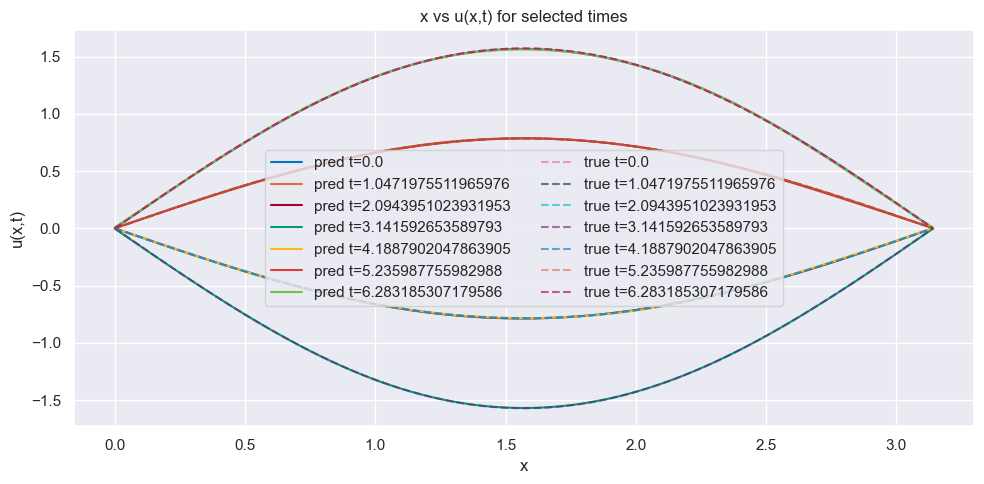

In [29]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=new_times, Nx =300, L_val=L, with_exact=True)

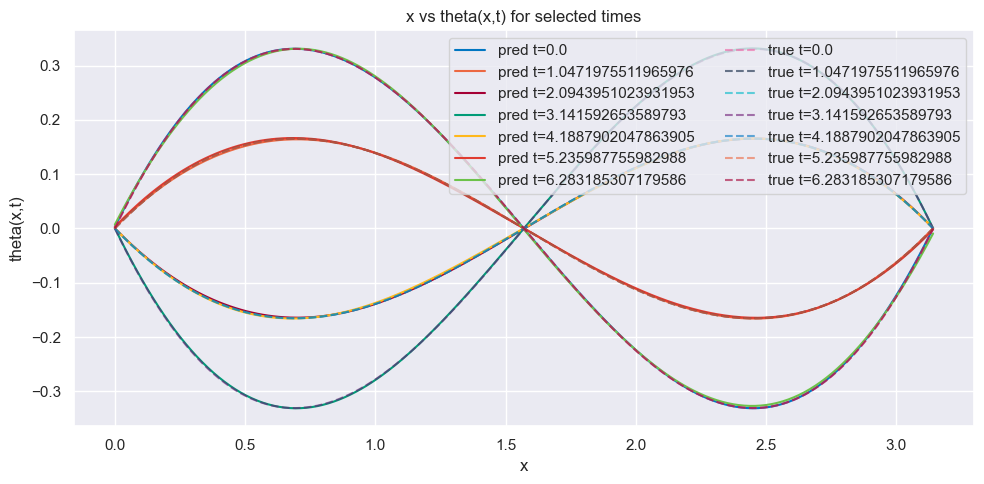

In [24]:
# Plot x vs theta(x,t) for multiple time instants using the trained model

def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the second for theta
            _, theta_pred_output = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            _, theta_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, theta_cpu in curves:
        plt.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if theta(x,t) is defined above
    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), theta_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('theta(x,t)')
    plt.title('x vs theta(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for theta
plot_x_vs_theta_at_times(pinn, times=new_times, Nx=300, L_val=L, with_exact=True)

In [25]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    out_n = pinn(torch.cat([xg_n, tg_n], dim=1))
    u_n, theta_n = out_n.split(1, dim=-1)

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
theta_pred = theta_normalizer.denormalize(theta_n).cpu().numpy().reshape(Nx, Nt)

u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
theta_true = theta_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100
R_theta = np.linalg.norm(theta_pred - theta_true) / np.linalg.norm(theta_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (theta): {R_theta:.6f}%")

Grid relative error (u):     0.202694%
Grid relative error (theta): 0.397273%
